<a href="https://colab.research.google.com/github/swamptoday/colab-files/blob/main/ML_Labs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Features:
1. Fine Fuel Moisture Code (FFMC) - a numeric rating of the moisture content of litter and other cured fine fuels.
1. Duff Moisture Code (DMC) -  a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth.
1. Drought Code (DC) - a numeric rating of the average moisture content of deep, compact organic layers.
1. Initial Spread Index (ISI) - a measure of the head fire indicator and rate of fire spread.
1. Relative Humidity (RH) - a measure of how much water vapor is in a water-air mixture compared to the maximum amount possible.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score, log_loss,precision_score, recall_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay

# Lab 01

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/forestfires.csv')

print(df)

In [ ]:
numeric_data = pd.DataFrame(df.drop(columns=['area']).select_dtypes(include=['float64', 'int64']))
categorical_data = pd.DataFrame(df.drop(columns=['area']).select_dtypes(exclude=['float64', 'int64']))

numeric_data_wo = pd.DataFrame(df.select_dtypes(include=['float64', 'int64']))

## Первинний аналіз даних: к-сть даних та кількість змінних, типи дани вхідних та вихідної змінної.

In [ ]:
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


### Кількість даних та змінних

In [ ]:
# shape of data
print(f'Shape of data: {df.shape}')

# amount of rows (data)
print(f'Amount of rows: {df.shape[0]}')

# amount of columns (variables)
print(f'Amount of columns: {df.shape[1]}')

Shape of data: (517, 13)
Amount of rows: 517
Amount of columns: 13


### Дублікати

In [ ]:
# amount of duplicates
print(f'Amount of duplicates: {df.duplicated().sum()}')

duplicates = df[df.duplicated(keep=False)]
print(duplicates)

Amount of duplicates: 4
     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
52   4  3   aug  wed  92.1  111.2  654.1   9.6  20.4  42   4.9   0.0   0.00
53   4  3   aug  wed  92.1  111.2  654.1   9.6  20.4  42   4.9   0.0   0.00
99   3  4   aug  sun  91.4  142.4  601.4  10.6  19.8  39   5.4   0.0   0.00
100  3  4   aug  sun  91.4  142.4  601.4  10.6  19.8  39   5.4   0.0   0.00
214  4  4   mar  sat  91.7   35.8   80.8   7.8  17.0  27   4.9   0.0  28.66
215  4  4   mar  sat  91.7   35.8   80.8   7.8  17.0  27   4.9   0.0  28.66
302  3  6   jun  fri  91.1   94.1  232.1   7.1  19.2  38   4.5   0.0   0.00
303  3  6   jun  fri  91.1   94.1  232.1   7.1  19.2  38   4.5   0.0   0.00


### Типи даних

In [ ]:
print(f'Data types:\n{df.dtypes}')

Data types:
X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object


### Аналіз вихідної (target) змінної

In [ ]:
target_var = 'area'

print(df[target_var].describe())

print(f"\nArea is 0: {(df['area'] == 0.0).sum()} times")


count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

Area is 0: 247 times


## Однозмінний аналіз (univariate EDA)

### Для числових змінних: оцінити параметри дескриптивної статистики  [API: 1], розподіл, наявність статистичних викидів та пропущених даних  [API: 2] (аналіз вихідної змінної провести окремо)

#### Параметри дескриптивної статистики (вивід + діаграма)

In [ ]:
desc_st = df[numeric_data.columns].describe()

print(f'Descriptive statistic for numerical features:\n{desc_st}')

Descriptive statistic for numerical features:
                X           Y        FFMC         DMC          DC         ISI  \
count  517.000000  517.000000  517.000000  517.000000  517.000000  517.000000   
mean     4.669246    4.299807   90.644681  110.872340  547.940039    9.021663   
std      2.313778    1.229900    5.520111   64.046482  248.066192    4.559477   
min      1.000000    2.000000   18.700000    1.100000    7.900000    0.000000   
25%      3.000000    4.000000   90.200000   68.600000  437.700000    6.500000   
50%      4.000000    4.000000   91.600000  108.300000  664.200000    8.400000   
75%      7.000000    5.000000   92.900000  142.400000  713.900000   10.800000   
max      9.000000    9.000000   96.200000  291.300000  860.600000   56.100000   

             temp          RH        wind        rain  
count  517.000000  517.000000  517.000000  517.000000  
mean    18.889168   44.288201    4.017602    0.021663  
std      5.806625   16.317469    1.791653    0.295959  


In [ ]:
# Sorting to divide plots (by the mean value)
desc_st_sorted = desc_st.loc[:, desc_st.loc['mean'].sort_values(ascending=False).index]

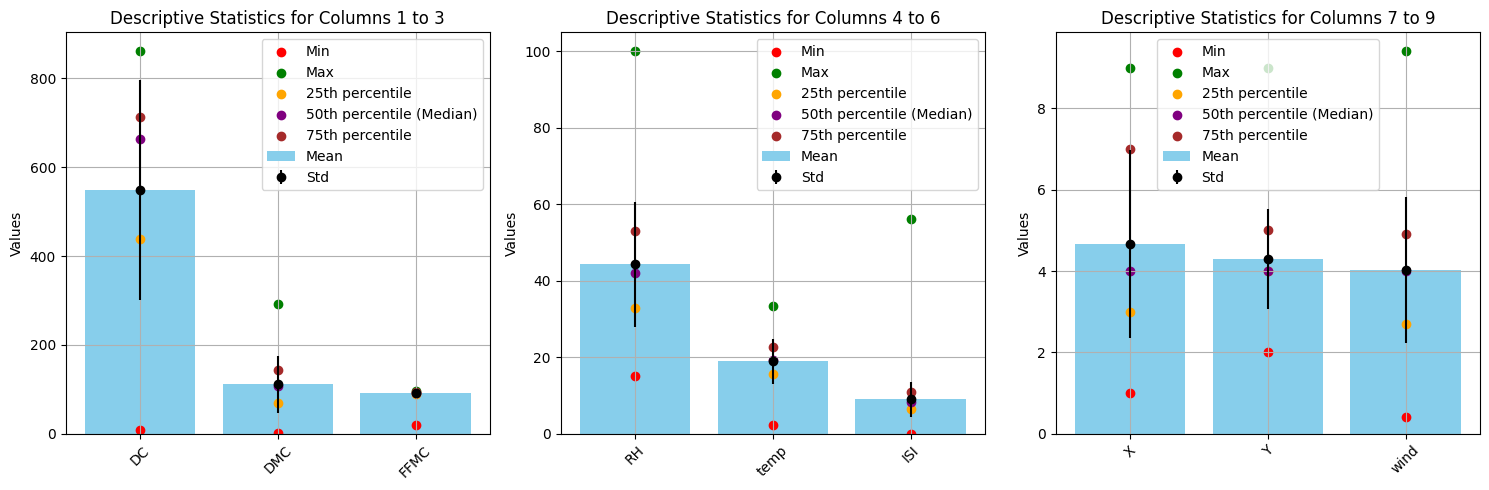

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# Number of columns to display per subplot
columns_per_subplot = 3

for i, ax in enumerate(axes):
    # Determine the start and end index of columns for current subplot
    start_idx = i * columns_per_subplot
    end_idx = start_idx + columns_per_subplot

    # Plot mean values as bar chart
    ax.bar(desc_st_sorted.columns[start_idx:end_idx], desc_st_sorted.loc['mean'][start_idx:end_idx], color='skyblue', label='Mean')
    # Plot error bars representing standard deviation
    ax.errorbar(desc_st_sorted.columns[start_idx:end_idx], desc_st_sorted.loc['mean'][start_idx:end_idx], yerr=desc_st_sorted.loc['std'][start_idx:end_idx], fmt='o', color='black', label='Std')
    # Scatter plot for minimum values
    ax.scatter(desc_st_sorted.columns[start_idx:end_idx], desc_st_sorted.loc['min'][start_idx:end_idx], color='red', label='Min')
    # Scatter plot for maximum values
    ax.scatter(desc_st_sorted.columns[start_idx:end_idx], desc_st_sorted.loc['max'][start_idx:end_idx], color='green', label='Max')
    # Scatter plot for 25th percentile
    ax.scatter(desc_st_sorted.columns[start_idx:end_idx], desc_st_sorted.loc['25%'][start_idx:end_idx], color='orange', label='25th percentile')
    # Scatter plot for median (50th percentile)
    ax.scatter(desc_st_sorted.columns[start_idx:end_idx], desc_st_sorted.loc['50%'][start_idx:end_idx], color='purple', label='50th percentile (Median)')
    # Scatter plot for 75th percentile
    ax.scatter(desc_st_sorted.columns[start_idx:end_idx], desc_st_sorted.loc['75%'][start_idx:end_idx], color='brown', label='75th percentile')

    ax.set_title(f'Descriptive Statistics for Columns {start_idx+1} to {end_idx}')

    ax.set_ylabel('Values')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


#### Розподіл, наявність статистичних викидів та пропущених даних

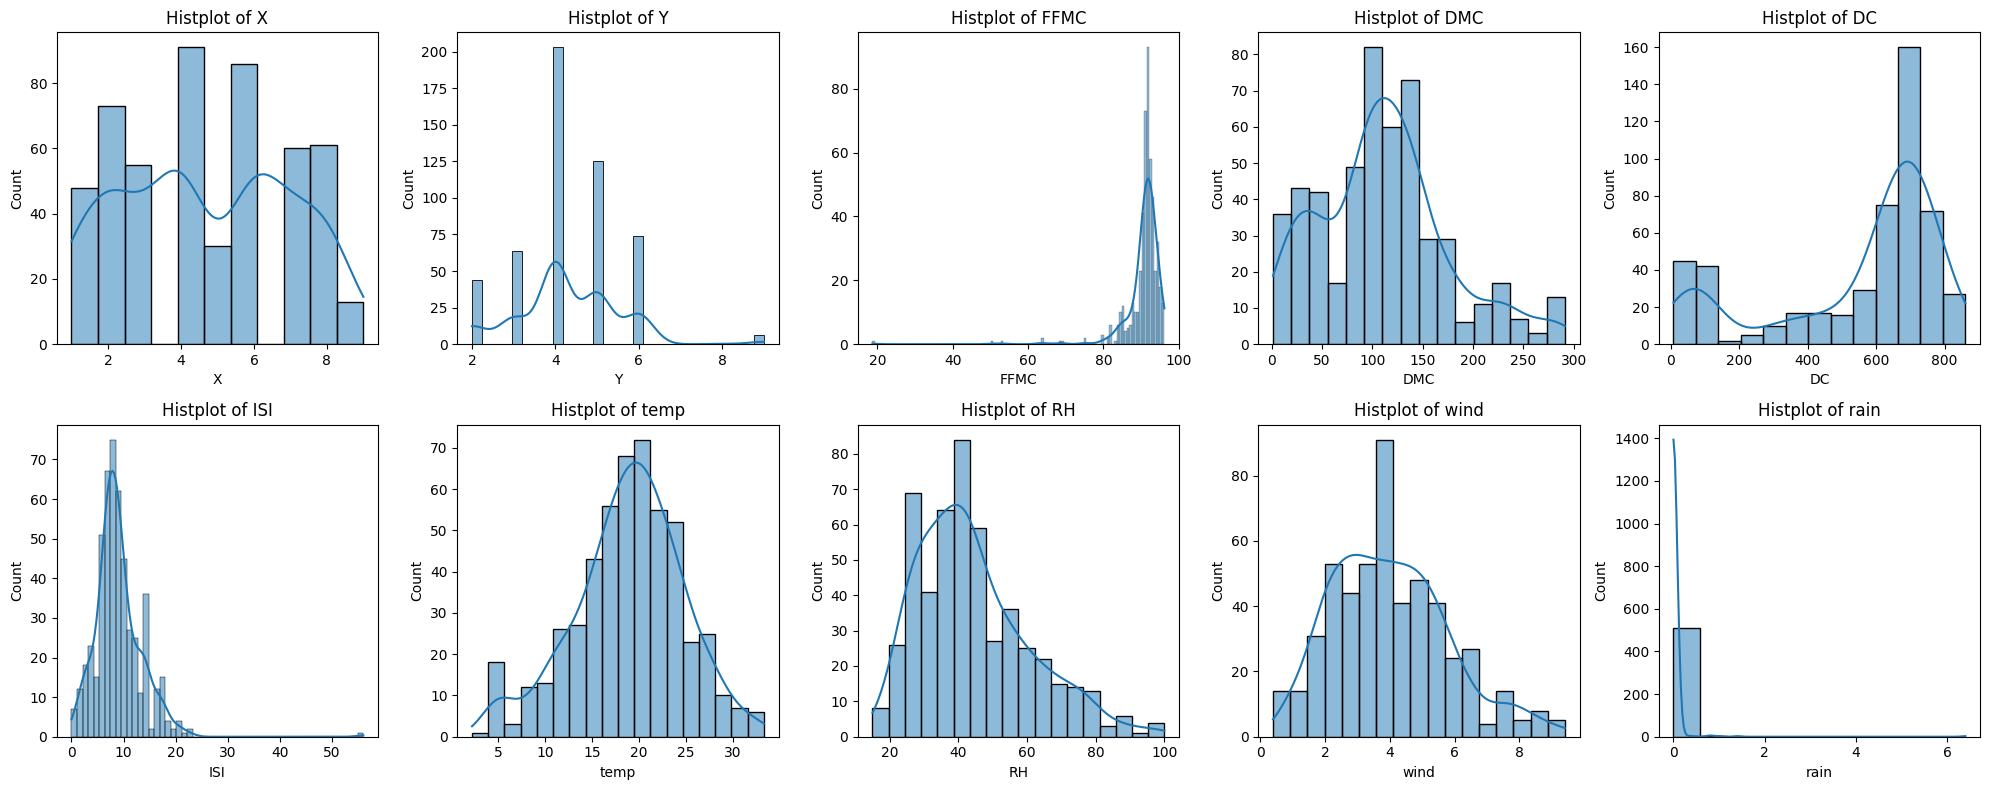

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# flatten so we can iterate like axes[i] instead of axes[i][j] (from shape (2, 5) to (1, 10))
axes = axes.flatten()

for i, data in enumerate(numeric_data):
    sns.histplot(x=df[data], ax=axes[i], kde=True)
    axes[i].set_title(f"Histplot of {data}")

plt.tight_layout()
plt.show()

*Нотатка*:

X, Y - spatial data, яка вже "регіоналізована"

FFMC - правостороння асиметрія

DC - лівостороння асиметрія

ISI - лівостороння асиметрія

Wind - лівостороння асиметрія

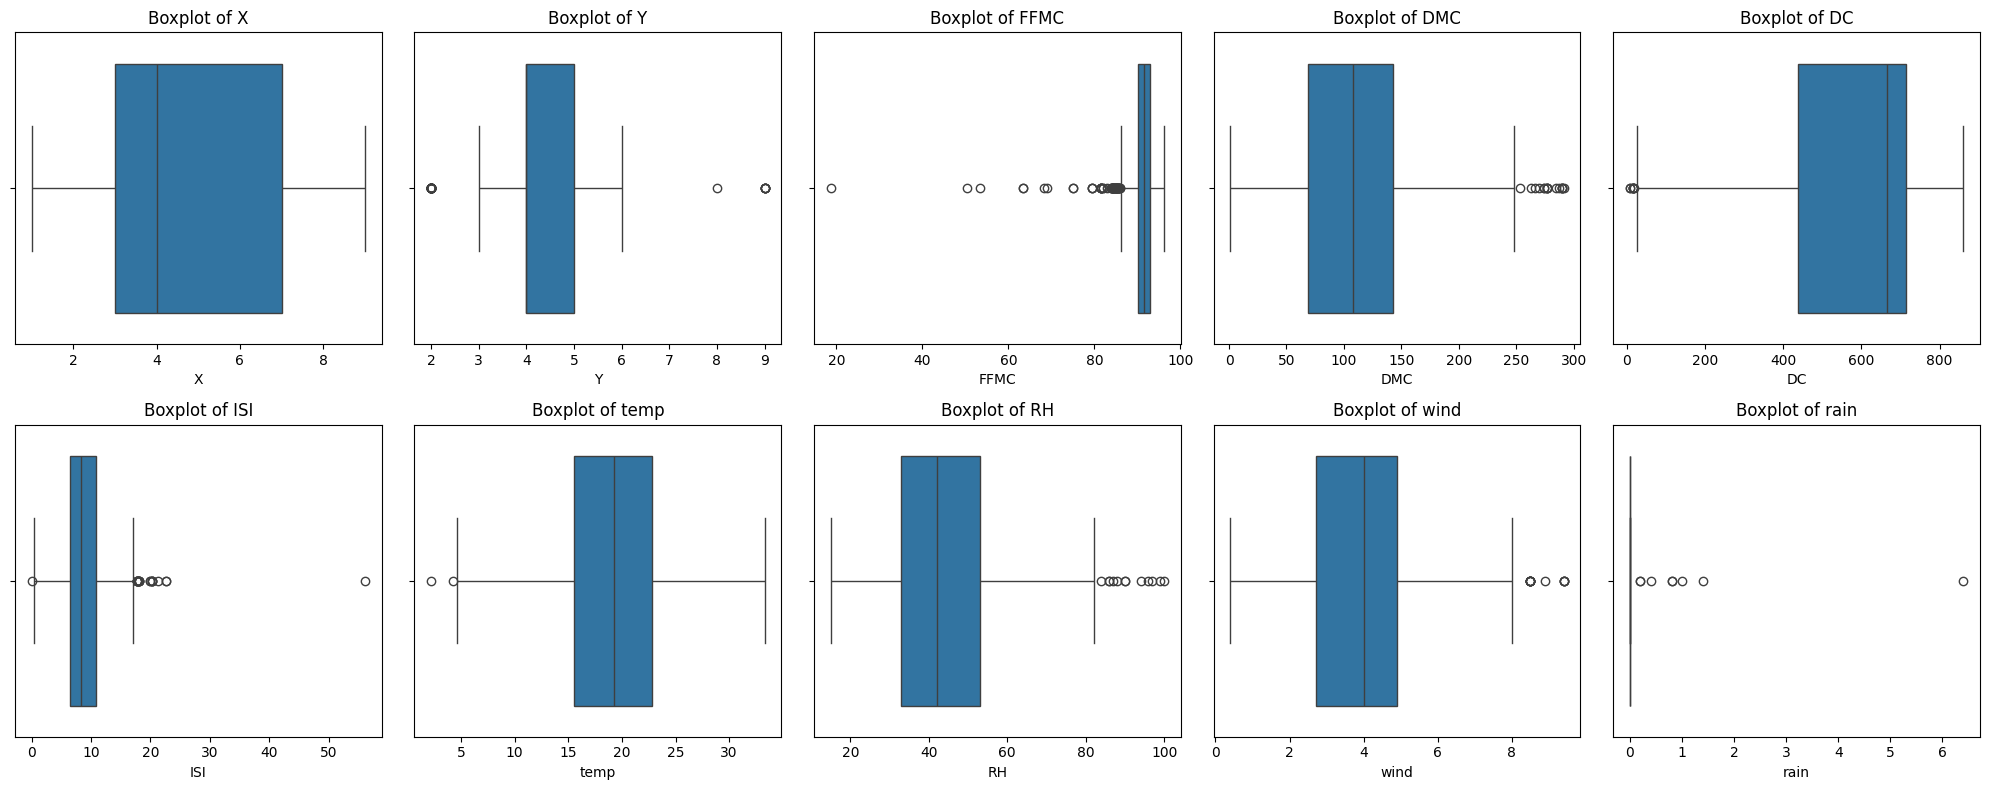

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# flatten so we can iterate like axes[i] instead of axes[i][j] (from shape (2, 5) to (1, 10))
axes = axes.flatten()

for i, data in enumerate(numeric_data):
    sns.boxplot(x=df[data], ax=axes[i])
    axes[i].set_title(f"Boxplot of {data}")

plt.tight_layout()
plt.show()

In [ ]:
for column in numeric_data:
  miss_values = df[column].isnull().sum()
  print(f'Missing values in {column}: {miss_values}')

Missing values in X: 0
Missing values in Y: 0
Missing values in FFMC: 0
Missing values in DMC: 0
Missing values in DC: 0
Missing values in ISI: 0
Missing values in temp: 0
Missing values in RH: 0
Missing values in wind: 0
Missing values in rain: 0


<Axes: >

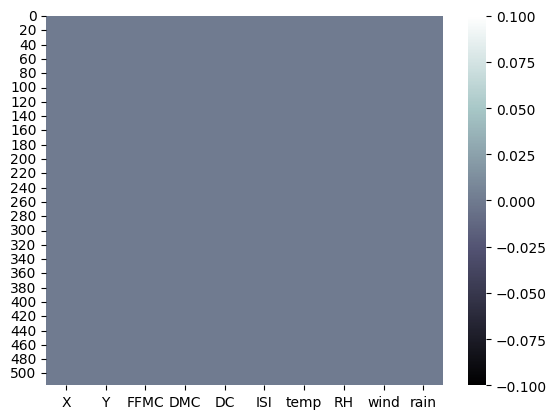

In [ ]:
# if there would be any missing data - we could use seaborn heatmap:
missing_data = df[numeric_data.columns].isnull()

sns.heatmap(missing_data, cmap='bone')

#### Аналіз вихідної змінної

In [ ]:
def addlabels(x, y, j):
    for i in range(len(x)):
        axes[j].text(i, y[i], round(y[i], 2), ha='center')

Descriptive statistics for 'area':
count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64


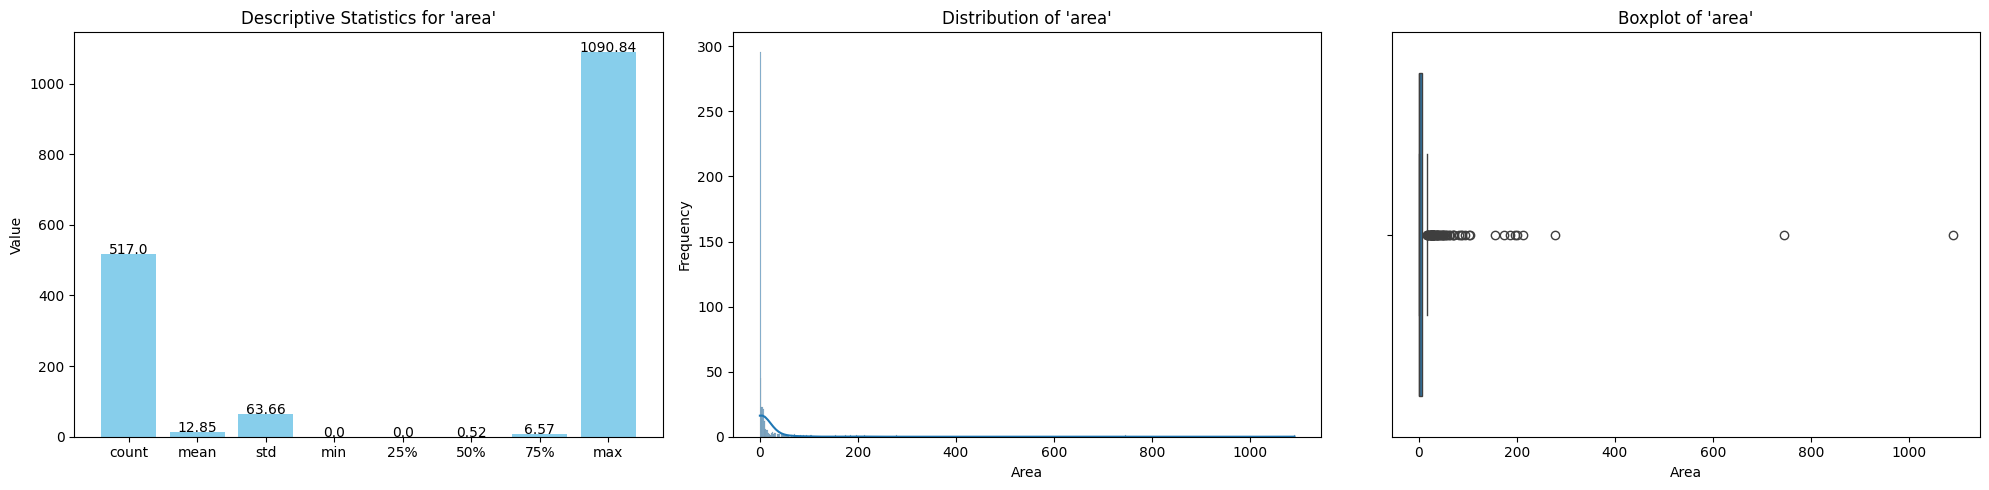

In [ ]:
area_desc_stats = df['area'].describe()
print("Descriptive statistics for 'area':")
print(area_desc_stats)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

axes[0].bar(area_desc_stats.index, area_desc_stats.values, color='skyblue')
addlabels(area_desc_stats.index, area_desc_stats.values, 0)
axes[0].set_title("Descriptive Statistics for 'area'")
axes[0].set_ylabel("Value")

sns.histplot(df['area'], kde=True, ax=axes[1])
axes[1].set_title("Distribution of 'area'")
axes[1].set_xlabel("Area")
axes[1].set_ylabel("Frequency")

sns.boxplot(x=df['area'], ax=axes[2])
axes[2].set_title("Boxplot of 'area'")
axes[2].set_xlabel("Area")
# ax.bar_labels(ax.container[0])
plt.tight_layout()
plt.show()

### *(для СА-33)* Для змінних з “сильно” асиметричним розподілом підібрати нелінійне перетворення для нормалізації розподілу;

/usr/local/lib/python3.10/dist-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


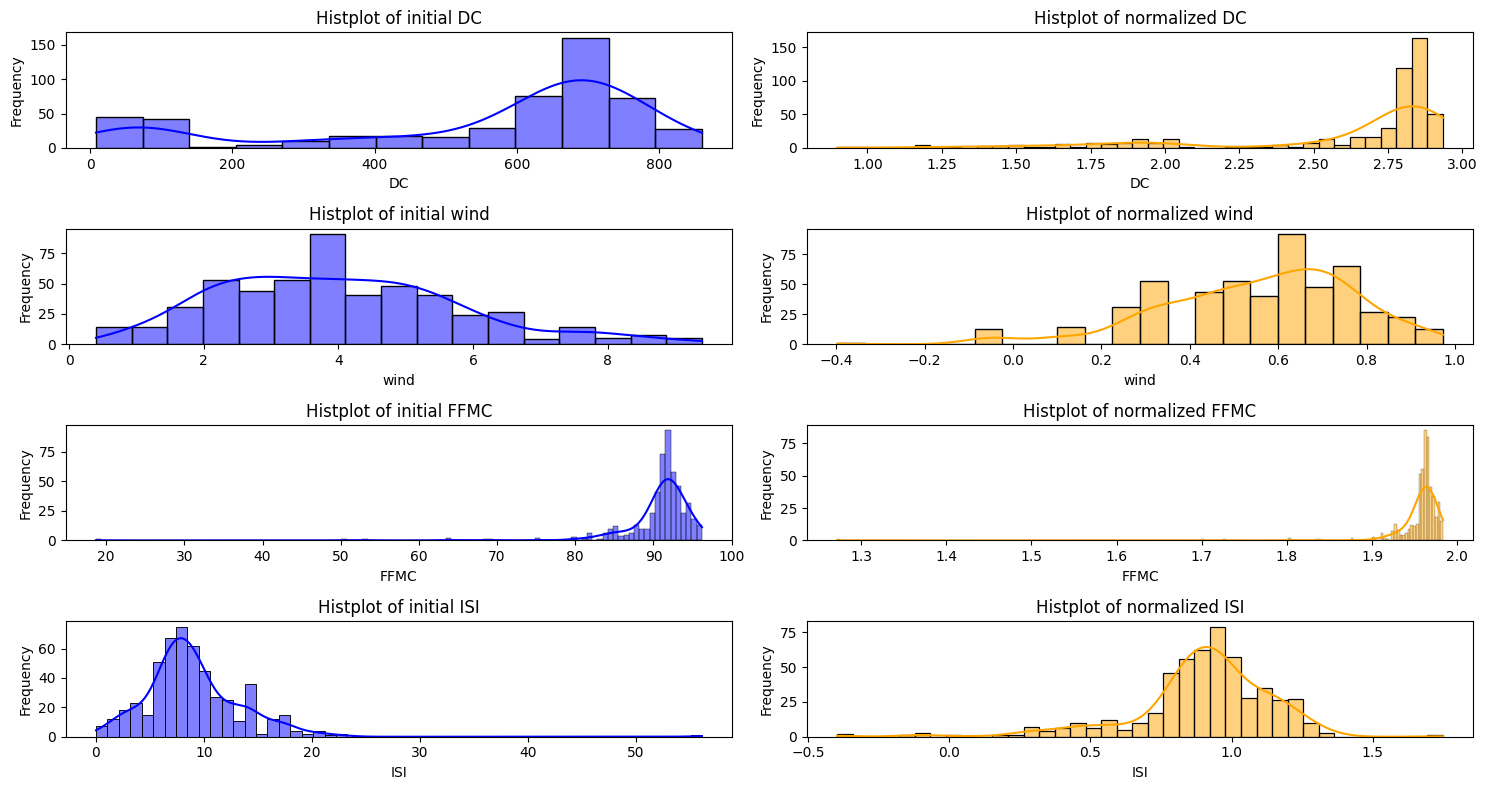

In [ ]:
# scaler = MinMaxScaler() # StandardScaler()
# norm_df = pd.DataFrame((scaler.fit_transform(df[['DC', 'wind']])), columns=['DC', 'wind'])
# print(norm_df)

# norm_df = pd.DataFrame(normalize(df[['DC', 'wind']],  norm='l1'), columns=['DC', 'wind'])

columns = ['DC', 'wind', 'FFMC', 'ISI']
norm_df = np.log10(df[columns])


fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 8))
axes = axes.flatten()


i = 0

for column, ax in zip(columns, axes):
  sns.histplot(x=df[column], kde=True, ax=axes[i], color='blue')
  axes[i].set_title(f"Histplot of initial {column}")
  axes[i].set_xlabel(column)
  axes[i].set_ylabel('Frequency')
  sns.histplot(x=norm_df[column], kde=True, ax=axes[i+1], color='orange')
  axes[i+1].set_title(f"Histplot of normalized {column}")
  axes[i+1].set_xlabel(column)
  axes[i+1].set_ylabel('Frequency')
  i += 2
# exponent
plt.tight_layout()
plt.show()


### Для категоріальних змінних: оцінити розподіл та баланс категорій, кількість пропущених даних  [API: 4];

In [ ]:
def addlabels(x, y, j):
    for i in range(len(x)):
        axes[j].text(i, y[i], round(y[i], 2), ha='center')

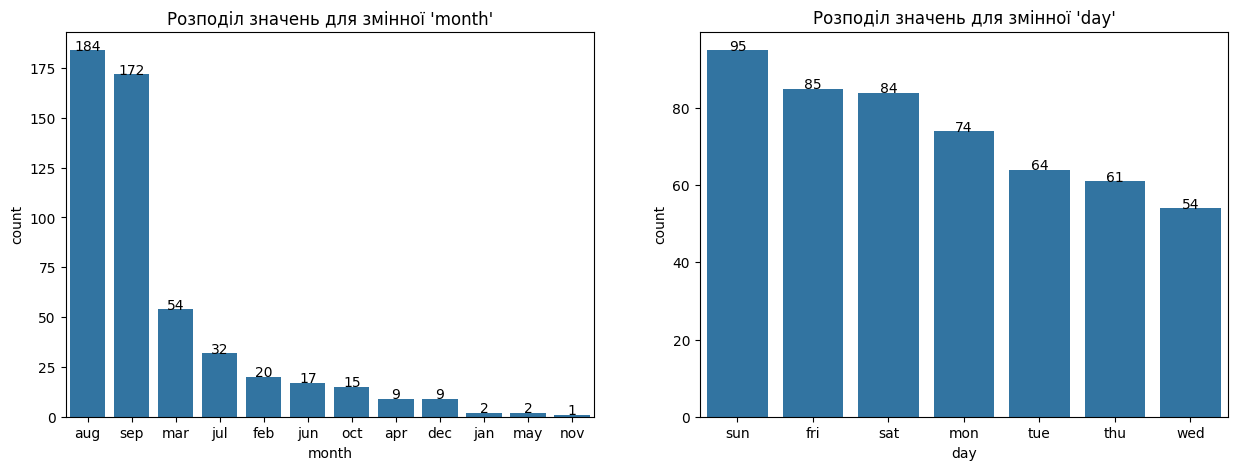

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, column in enumerate(categorical_data.columns):
  sns.countplot(data=categorical_data, x=column, ax=axes[i], order=categorical_data[column].value_counts().index)
  addlabels(categorical_data[column].value_counts().index, categorical_data[column].value_counts().values, i)
  axes[i].set_title(f"Розподіл значень для змінної '{column}'")

plt.show()

In [ ]:
print("\n\nКількість пропущених даних:")
print(categorical_data.isnull().sum())



Кількість пропущених даних:
month    0
day      0
dtype: int64


### За потреби провести додатковий аналіз на сумісність, обмеження та/або коректність  змінних

In [ ]:
print("Унікальні значення для 'month':", df['month'].unique())
print("Унікальні значення для 'day':", df['day'].unique())

print(f"\nМінімальне та максимальне значення для 'temp': {df['temp'].min()} - {df['temp'].max()}")


Унікальні значення для 'month': ['mar' 'oct' 'aug' 'sep' 'apr' 'jun' 'jul' 'feb' 'jan' 'dec' 'may' 'nov']
Унікальні значення для 'day': ['fri' 'tue' 'sat' 'sun' 'mon' 'wed' 'thu']

Мінімальне та максимальне значення для 'temp': 2.2 - 33.3


## Двозмінній/багатозмінний аналіз (bivariate/multivariate EDA)

### Побудувати матрицю кореляції між числовими змінними (в тому числі з вихідною), зробити висновки [API: 5].

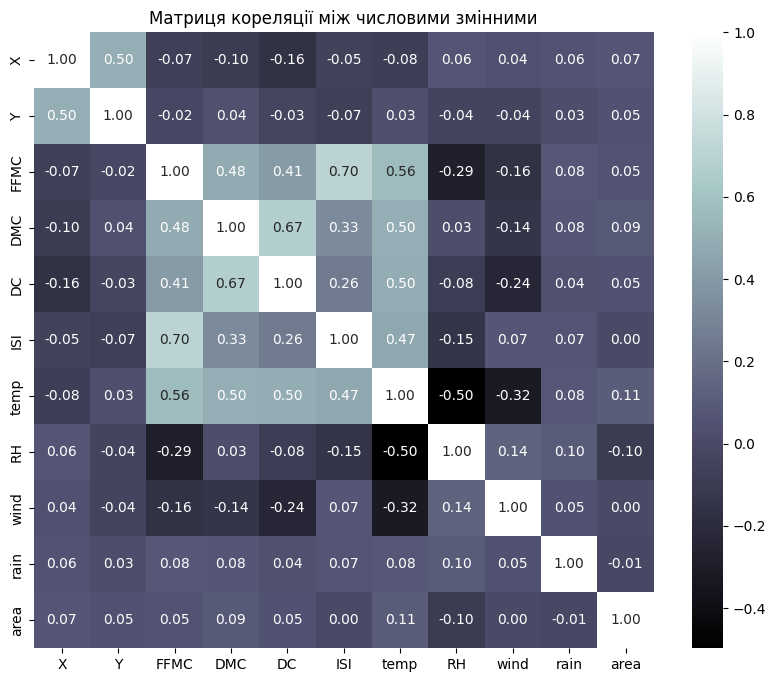

In [ ]:
super_total_new_numeric = numeric_data_wo[numeric_data_wo['area'] > 0]
correlation_matrix = super_total_new_numeric.corr()

print('\n')

fig, axes = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='bone', fmt=".2f", ax=axes)
axes.set_title('Матриця кореляції між числовими змінними')
plt.show()

Висновки: високу кореляцію мають значення X - Y: 0.54, FFMC - ISI: 0.53, DMC - DC: 0.68, temp - RH: -0.53.

Залежність temp - RH існує через природню залежніcть відносної вологості від температури.

Залежність X - Y - це залежність між spatial даними, може існувати через особливості регіоналізації (напевно???).

Залежність FFMC - ISI існує через залежність обох від вмісту вологи в паливі. Високе FFMC сприяє вищим значенням ISI.

Залежність DMC - DC існує через те, що обидва представляють вміст вологи в різних шарах органічного матеріалу в лісовій підстилці.


### Для пар змінних з високою кореляцією побудувати візуальне подання залежності [API: 6].

In [ ]:
threshold = 0.5

high_correlation_pairs = []

print("Strong correlation (>0.5/<-0.5):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            high_correlation_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j]))
            print(f"{correlation_matrix.index[i]} - {correlation_matrix.columns[j]}: {np.round(correlation_matrix.iloc[i, j], 2)}")


Strong correlation (>0.5/<-0.5):
FFMC - ISI: 0.7
FFMC - temp: 0.56
DMC - DC: 0.67
DMC - temp: 0.5


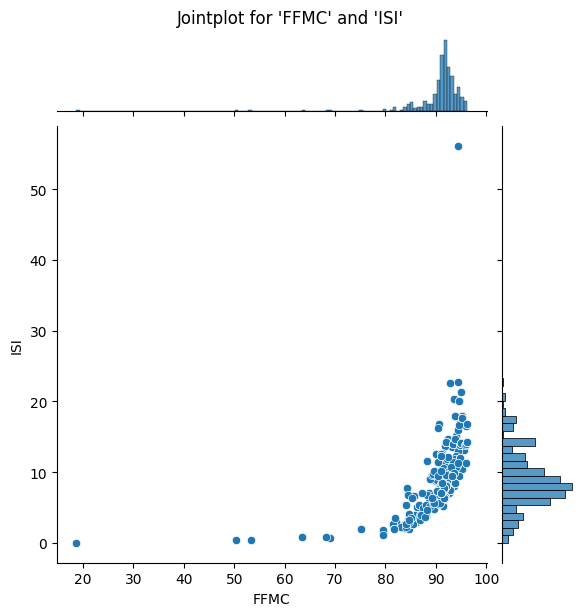

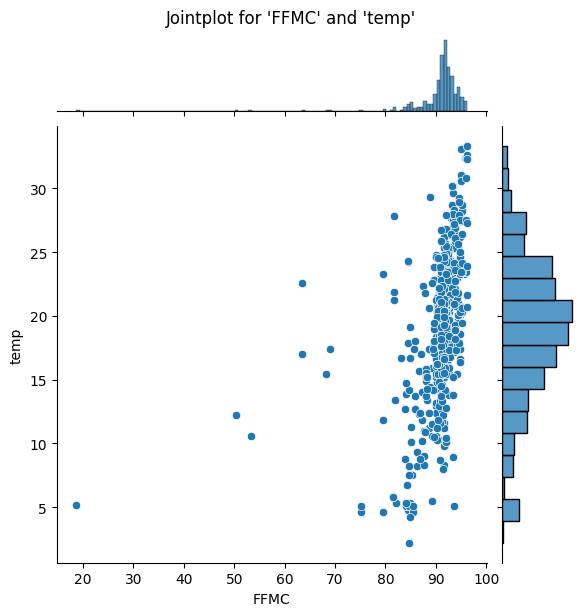

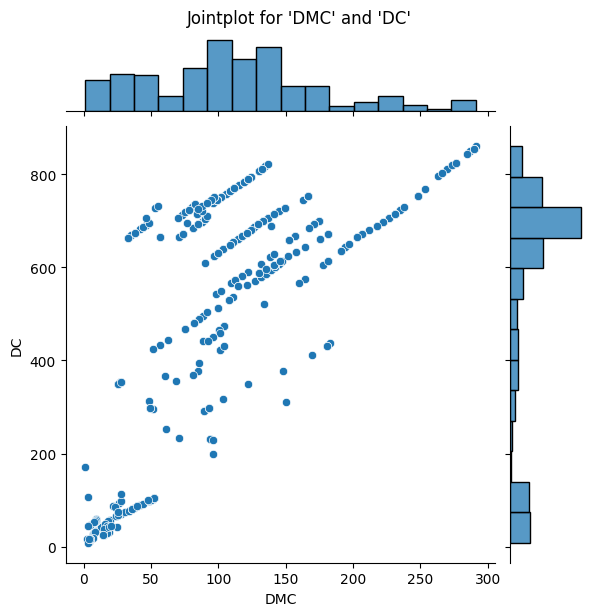

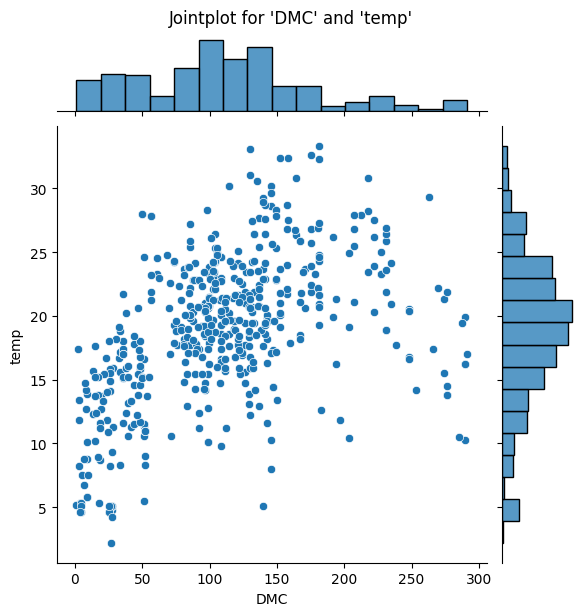

In [ ]:
for pair in high_correlation_pairs:
    sns.jointplot(data=df, x=pair[0], y=pair[1], kind='scatter')
    plt.suptitle(f"Jointplot for '{pair[0]}' and '{pair[1]}'", y=1.02)
    plt.show()

### (для СА-33) Оцінити mutual information score (MI) між вихідною змінною та числовими вхідними, отримані значення подати у вигляді відсортованого barplot [API: 7]. Порівняти MI оцінку з раніше отриманими коефіцієнтами кореляції.

In [ ]:
# Mutual information quantifies the amount of information obtained about one variable through the observation of another variable.
# In this context, it measures the dependency between each numerical feature in numeric_data and the target variable 'area'.

mi_scores = {}

for column in numeric_data.columns:
    # Compute mutual information score between the current column and the 'area' column
    mi_score = mutual_info_regression(numeric_data[[column]], df['area'])[0]
    mi_scores[column] = mi_score

# Convert the dictionary to a DataFrame
mi_scores_df = pd.DataFrame.from_dict(mi_scores, orient='index', columns=['MI Score'])

# Sort the DataFrame by MI Score in descending order
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False)


In [ ]:
correlation_without_area = correlation_matrix['area'].drop('area').reindex(mi_scores_df.index)

In [ ]:
def addlabels(x, y, j):
    for i in range(len(x)):
        axes[j].text(i, y[i], round(y[i], 2), ha='center')

<ipython-input-31-e290264fd5a5>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores_df.index, y=mi_scores_df['MI Score'], palette='viridis', ax=axes[0])
<ipython-input-31-e290264fd5a5>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_without_area.index, y=correlation_without_area.values, palette='viridis', ax=axes[1])


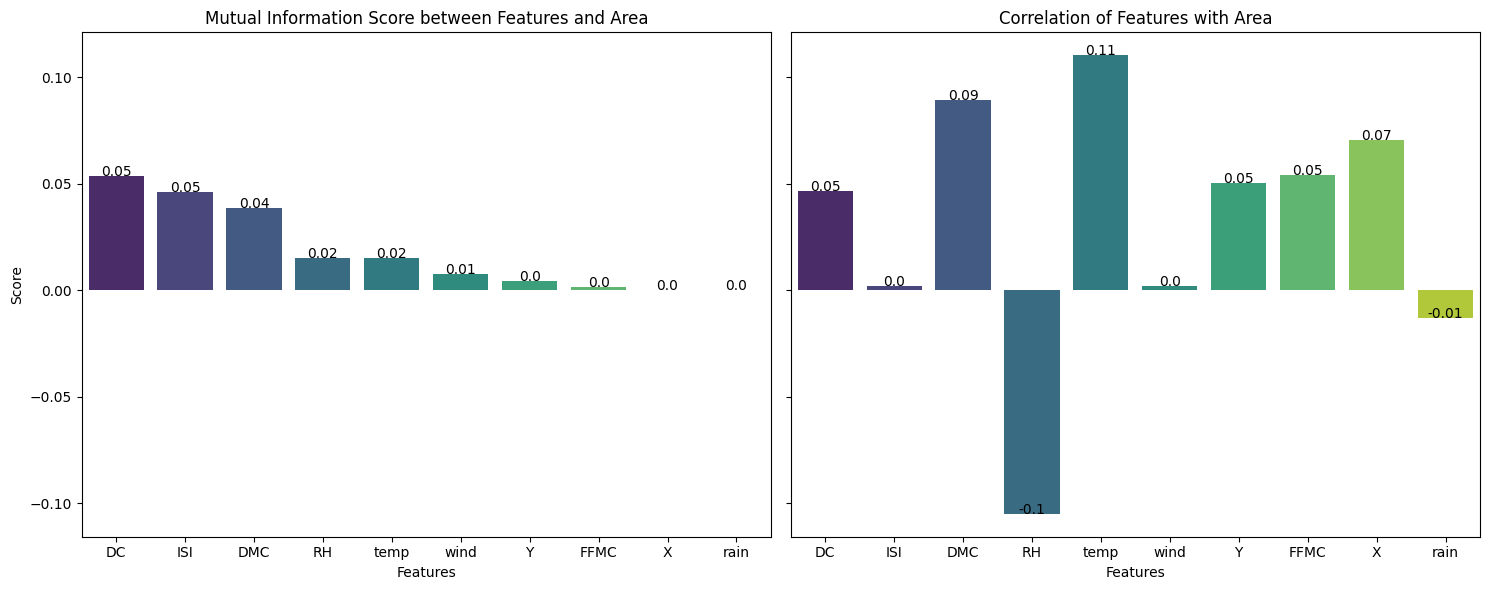

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey = True)

axes = axes.flatten()

sns.barplot(x=mi_scores_df.index, y=mi_scores_df['MI Score'], palette='viridis', ax=axes[0])
addlabels(mi_scores_df.index, mi_scores_df['MI Score'], 0)
axes[0].set_title('Mutual Information Score between Features and Area')
axes[0].set_xlabel('Features')
axes[0].set_ylabel('Score')


sns.barplot(x=correlation_without_area.index, y=correlation_without_area.values, palette='viridis', ax=axes[1])
addlabels(correlation_without_area.index, correlation_without_area.values, 1)
axes[1].set_xlabel('Features')
axes[1].set_title('Correlation of Features with Area')

plt.tight_layout()
plt.show()


### Оцінити розподіл та статистичні викиди вихідної змінної залежно від значень (кожної з) категоріальних змінних  [API: 3];

<ipython-input-32-cd6b5c89f311>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='area', y='month', data=df, palette='viridis', ax=axes[0])
<ipython-input-32-cd6b5c89f311>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='area', y='day', data=df, palette='mako', ax=axes[1])


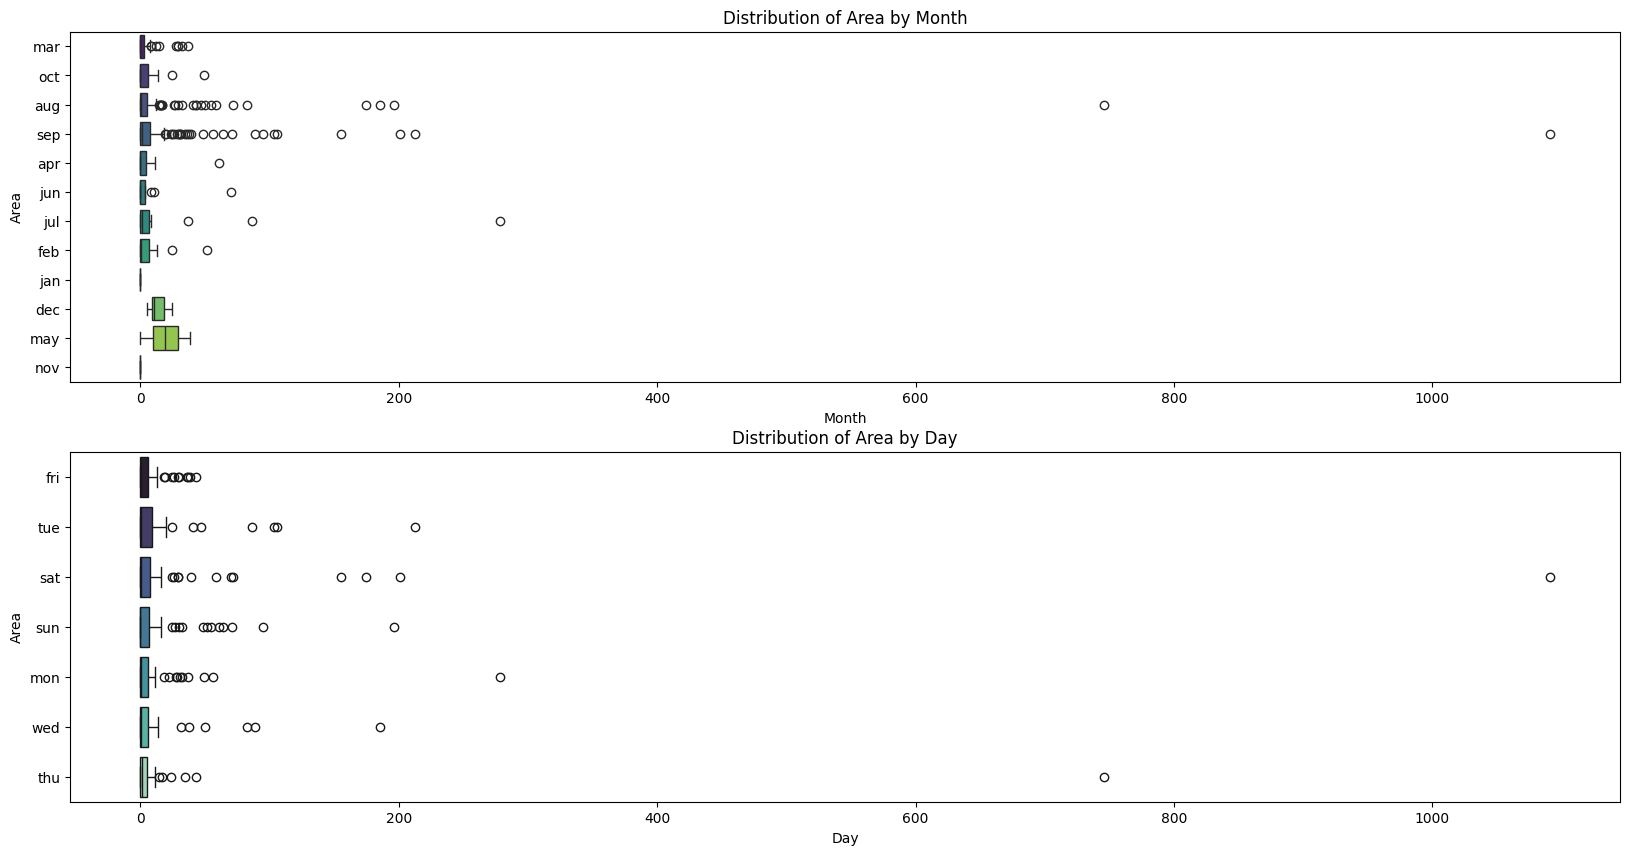

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

sns.boxplot(x='area', y='month', data=df, palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of Area by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Area')

sns.boxplot(x='area', y='day', data=df, palette='mako', ax=axes[1])
axes[1].set_title('Distribution of Area by Day')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Area')
plt.show()

In [ ]:
day_order = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

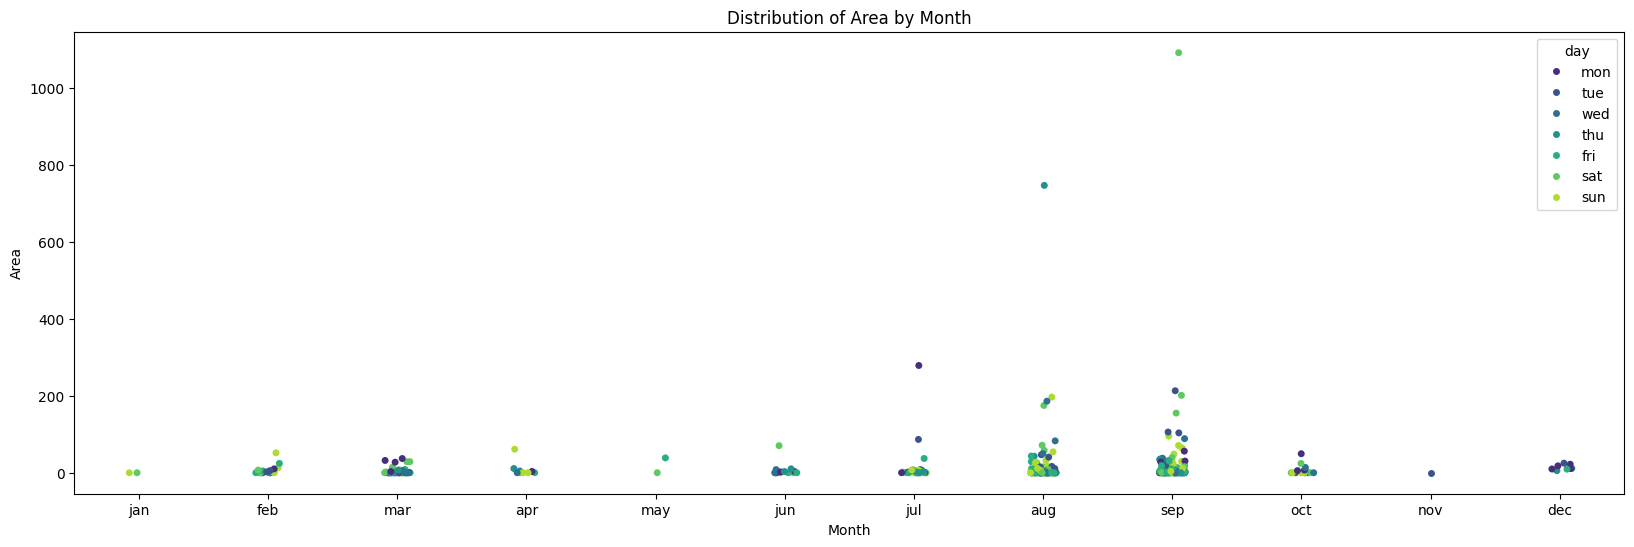

In [ ]:
fig, axes = plt.subplots(figsize=(20,6))

sns.stripplot(x='month', y='area', data=df, order=month_order, ax=axes, hue='day', hue_order=day_order, palette='viridis')
axes.set_title('Distribution of Area by Month')
axes.set_xlabel('Month')
axes.set_ylabel('Area')

plt.show()

### (для СА-33) Провести статистичні тести (t-тест чи ANOVA чи H-тест) для оцінки значущості різниці значення вихідної змінної залежно від значення категоріальної змінної (додати p-значення на діаграму).

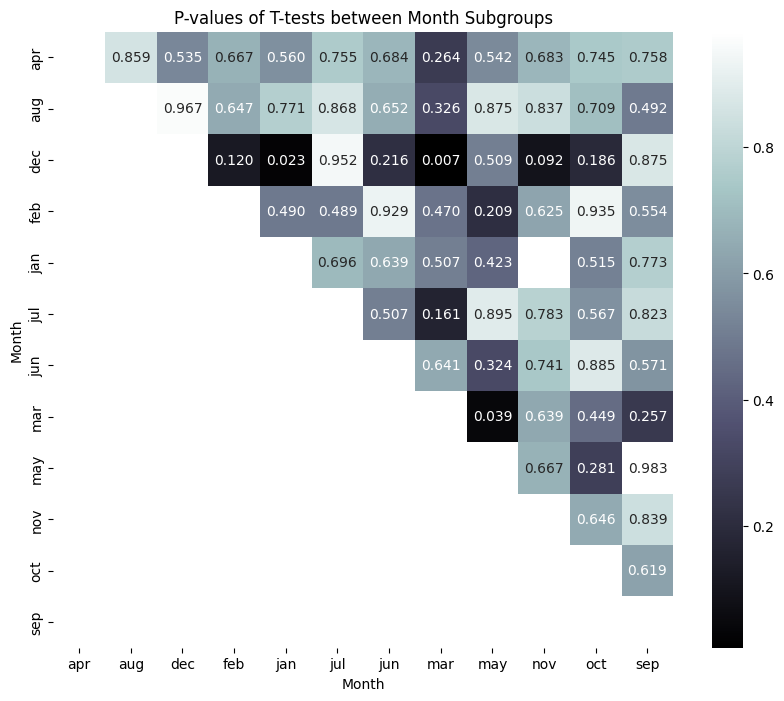

In [ ]:
# Explanation of independent two-sample t-test:
# The independent two-sample t-test compares the means of two independent groups to determine if there is a statistically significant difference between them.
# The null hypothesis (H0) assumes that there is no difference between the means of the two groups.
# The alternative hypothesis (H1) states that there is a difference between the means of the two groups.
# The t-test calculates a p-value, which represents the probability of observing the data if the null hypothesis is true.
# If the p-value is less than the chosen significance level (usually 0.05), the null hypothesis is rejected, indicating that there is a statistically significant difference between the groups.

# Group the data by month and select the 'area' column
month_subgroups = df.groupby('month')['area']

# Create pairs of month subgroups for comparison
pairs = [(m1, m2) for i, m1 in enumerate(month_subgroups) for j, m2 in enumerate(month_subgroups) if i < j]

p_values = np.zeros((len(month_subgroups), len(month_subgroups)))

# Initialize a list to store significant pairs of month subgroups (based on p-value < 0.05)
significant_pairs = []

# Perform t-tests between each pair of month subgroups
for i, (group1_name, group1) in enumerate(month_subgroups):
    for j, (group2_name, group2) in enumerate(month_subgroups):
        if i < j:
            # Perform independent two-sample t-test between the two month subgroups
            _, p_value = stats.ttest_ind(group1, group2)
            p_values[i, j] = p_value
            # Check if the p-value is less than 0.05 (indicating statistical significance)
            if p_value < 0.05:
                # If significant, add the pair of month subgroups and the corresponding p-value to the list
                significant_pairs.append((group1_name, group2_name, p_value))

# Create a DataFrame to store the p-values, using month names as row and column indices
p_values_df = pd.DataFrame(p_values, index=month_subgroups.groups.keys(), columns=month_subgroups.groups.keys())

# Plot a heatmap of the p-values
fig, axes = plt.subplots(figsize=(10, 8))
sns.heatmap(p_values_df, annot=True, fmt=".3f", cmap='bone', cbar=True, mask=(p_values_df == 0.0), ax=axes)
axes.set_title('P-values of T-tests between Month Subgroups')
axes.set_xlabel('Month')
axes.set_ylabel('Month')
plt.show()

Інтерпретація теплової карти:
Темніші клітинки представляють нижчі значення p, що вказує на більшу статистичну значущість.
Якщо p-значення між двома місяцями нижче порогу значущості (0,05), це свідчить про значну різницю в площі пожежі між цими місяцями.
Значущі пари, перелічені у списку 'significant_pairs', вказують, які пари місяців мають статистично значущі відмінності в площі пожежі.

In [ ]:
print("Significant p-values (p < 0.05):")
for group1, group2, p_value in significant_pairs:
    print(f"{group1} vs {group2}: p-value = {p_value:.3f}")

Significant p-values (p < 0.05):
dec vs jan: p-value = 0.023
dec vs mar: p-value = 0.007
mar vs may: p-value = 0.039


### (для СА-33) Для обраної пари категоріальних змінних побудувати 2D розподіл, на її базі побудувати гіпотезу та протестувати її за χ² тестом.

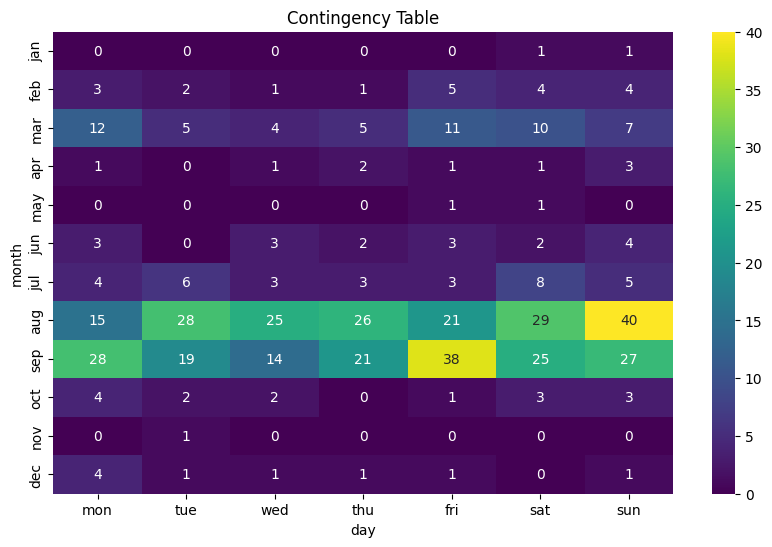

Chi-square statistic: 64.24
P-value: 0.5384
Degrees of freedom: 66
Fail to reject null hypothesis: There is no statistically significant relationship between the categorical variables.


In [ ]:
# Explanation of the Chi-square test of independence:
# The Chi-square test assesses the association between two categorical variables by comparing observed frequencies with expected frequencies.
# Null hypothesis (H0): There is no association between the two variables (they are independent).
# Alternative hypothesis (H1): There is an association between the variables.
# The test calculates a Chi-square statistic, which represents the discrepancy between observed and expected frequencies.
# The p-value associated with the Chi-square statistic indicates the probability of observing the data if the null hypothesis is true.
# If the p-value is less than the chosen significance level (usually 0.05), the null hypothesis is rejected, suggesting a significant relationship.
# Degrees of freedom (dof) represent the number of categories minus 1 for each variable and affect the interpretation of the Chi-square statistic.
# The contingency table visually presents observed frequencies of variable combinations, while expected frequencies are derived assuming independence.


# Create a contingency table (cross-tabulation) of 'month' and 'day'
contingency_table = pd.crosstab(df['month'], df['day'])

# Reindex the contingency table to match specified orders of months and days
contingency_table = contingency_table.reindex(index=month_order, columns=day_order)

# Plot a heatmap of the contingency table
fig, axes = plt.subplots(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, cmap='viridis', cbar=True, ax=axes)
axes.set_title('Contingency Table')
axes.set_xlabel('day')
axes.set_ylabel('month')
plt.show()

# Perform the Chi-square test of independence
chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)

# Print the Chi-square statistic, p-value, and degrees of freedom
print(f"Chi-square statistic: {chi2_stat:.2f}")
print(f"P-value: {p_val:.4f}")
print(f"Degrees of freedom: {dof}")

# Set the significance level (alpha)
alpha = 0.05

# Determine whether to reject or fail to reject the null hypothesis based on the p-value
if p_val < alpha:
    print("Reject null hypothesis: There is a statistically significant relationship between the categorical variables.")
else:
    print("Fail to reject null hypothesis: There is no statistically significant relationship between the categorical variables.")


1. No missing values
1. Int values for regionalised spatial data description. Should we convert to float?
1. Lots of outliers - choose what to do with them: trimming weight, Winsorisation, trimming, imputation or using robust estimation techniques.
1. Area (output variable) - almost half is 0.0 (247). Should we do something about that?
1. Duplicates - remove.
1. Perform values normalization/scaling.

# Lab 02

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/forestfires.csv')

print(df)

In [ ]:
df_filtered = df[df['area'] != 0]

In [ ]:
metrics=[]
real_metrics=[]

## На базі EDA проведено у 1 ЛР побудувати пайплайн препроцесингу даних [API: 1]:
* (за потреби) очистити дані від рядків чи колонок, заповнити пропущені значення;
* (за потреби) нормалізувати та/чи масштабувати чисельні змінні (включно з вихідною);
* (за потреби) енкодувати категоріальні дані обраним методом (наприклад target-енкодування);


### Feature selection and categorization (numerical/categorical)

In [ ]:
categorical_features = df_filtered.drop(columns=['area', 'RH']).select_dtypes(exclude=['float64']).columns

numerical_features = df_filtered.drop(columns=['area', 'X', 'Y']).select_dtypes(include=['int64', 'float64']).columns

### Check of outliers to decide what scaling to use (Standard/Robust)

In [ ]:
def detect_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return np.sum(outliers), np.mean(outliers)

In [ ]:
for column in numerical_features:
  num_outliers, percentage_outliers = detect_outliers(df_filtered[column])
  print(f"Number of outliers in {column}:", num_outliers)
  print(f"Percentage of outliers {column}:", percentage_outliers * 100, "%\n")



Number of outliers in FFMC: 29
Percentage of outliers FFMC: 10.74074074074074 %

Number of outliers in DMC: 16
Percentage of outliers DMC: 5.9259259259259265 %

Number of outliers in DC: 34
Percentage of outliers DC: 12.592592592592592 %

Number of outliers in ISI: 6
Percentage of outliers ISI: 2.2222222222222223 %

Number of outliers in temp: 13
Percentage of outliers temp: 4.814814814814815 %

Number of outliers in RH: 3
Percentage of outliers RH: 1.1111111111111112 %

Number of outliers in wind: 12
Percentage of outliers wind: 4.444444444444445 %

Number of outliers in rain: 2
Percentage of outliers rain: 0.7407407407407408 %



### Creating needed transformers

1. Removing duplicates from df

2. Removing rows, where area = 0

In [ ]:
class RemoveDuplicatesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop_duplicates()

### Creating instances of custom tranformer classes

In [ ]:
remove_duplicates_transformer = RemoveDuplicatesTransformer()

### Creating transforming pipelines for categorical and numerical features

In [ ]:
categorical_transformer = Pipeline(
    [
      ('encoder', OneHotEncoder(handle_unknown='ignore')),
    ]
)

In [ ]:
numerical_transformer = Pipeline(
    [
      ('scaler', StandardScaler())
    ]
)

### Creating preprocessor

In [ ]:
preprocessor = Pipeline([
    #('remove_duplicates', remove_duplicates_transformer),
    ('preprocess', ColumnTransformer([
        ('categoricals', categorical_transformer, categorical_features),
        ('numericals', numerical_transformer, numerical_features)
    ]))
])

## Розділити дані на тренувальну та тестову вибірки, “навчити” препроцесинг на тренувальній вибірці, перетворити тренувальну та тестову вибірки

### Checking if there are classes which has one member representation

In [ ]:
for feature in categorical_features:
  value_counts = pd.Series(df_filtered[feature]).value_counts()
  classes_with_one_member = value_counts[value_counts == 1].index.tolist()
  if (len(classes_with_one_member) != 0):
    print(f"Classes in {feature} represented by only one member:", classes_with_one_member)

Classes in Y represented by only one member: [8]
Classes in month represented by only one member: ['may']


There are((

Create duplicates to have at least 4 members???

In [ ]:
def duplicate_classes(df_filtered, categorical_features, min_instances=4):
    """
    Duplicate instances with classes represented by less than min_instances members in categorical features.

    Parameters:
    - df (DataFrame): Input DataFrame.
    - categorical_features (list): List of categorical feature names.
    - min_instances (int): Minimum number of instances for each class. Default is 4.

    Returns:
    - DataFrame: DataFrame with duplicated instances.
    """
    for feature in categorical_features:
        value_counts = df_filtered[feature].value_counts()
        classes_to_duplicate = value_counts[value_counts < min_instances].index.tolist()

        # Iterate over classes to duplicate
        for class_label in classes_to_duplicate:
            # Find the rows where this class is present
            row_indices = df_filtered[df_filtered[feature] == class_label].index

            # Duplicate rows until the class has at least min_instances members
            while len(row_indices) < min_instances:
                duplicated_row = df_filtered.loc[row_indices[0]]
                df_filtered = df_filtered.append(duplicated_row, ignore_index=True)
                row_indices = df_filtered[df_filtered[feature] == class_label].index

    return df_filtered


In [ ]:
df_filtered = duplicate_classes(df_filtered, categorical_features)

<ipython-input-49-362b00d97553>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_filtered = df_filtered.append(duplicated_row, ignore_index=True)
<ipython-input-49-362b00d97553>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_filtered = df_filtered.append(duplicated_row, ignore_index=True)


### Splitting train and test sets

In [ ]:
X = df_filtered.drop(columns=['area'])
y = df_filtered['area']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, np.log(y+1), stratify=X[['month']], random_state=42)

### [FAILED (need to use stratify)] To check for categorical value distribution

In [ ]:
for feature in categorical_features:
    train_unique_values = set(X_train[feature].unique())
    test_unique_values = set(X_test[feature].unique())
    print(f"{feature} in train: {sorted(X_train[feature].unique())}")
    print(f"{feature} in test: {sorted(X_test[feature].unique())}")

    if train_unique_values == test_unique_values:
        print(f"All types of {feature} are present in both train and test sets.\n")
    else:
        print(f"Some types of {feature} are missing in one of the sets.\n")

X in train: [1, 2, 3, 4, 5, 6, 7, 8, 9]
X in test: [1, 2, 3, 4, 5, 6, 7, 8, 9]
All types of X are present in both train and test sets.

Y in train: [2, 3, 4, 5, 6, 8, 9]
Y in test: [2, 3, 4, 5, 6, 8, 9]
All types of Y are present in both train and test sets.

month in train: ['apr', 'aug', 'dec', 'feb', 'jul', 'jun', 'mar', 'may', 'oct', 'sep']
month in test: ['apr', 'aug', 'dec', 'feb', 'jul', 'jun', 'mar', 'may', 'oct', 'sep']
All types of month are present in both train and test sets.

day in train: ['fri', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed']
day in test: ['fri', 'mon', 'sat', 'sun', 'thu', 'tue', 'wed']
All types of day are present in both train and test sets.



### Preprocessor fit-transform

In [ ]:
preprocessor.fit(X_train)

X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

## Побудувати модель звичайної лінійної регресії LinearRegression

### Навчити модель на всіх наявних вхідних змінних, протестувати модель за поданими метриками;

In [ ]:
model = LinearRegression()
model.fit(X_train_processed, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_test_processed)

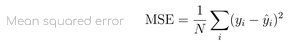

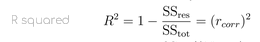

In [ ]:
# Mean Squared Error (MSE):

#     The Mean Squared Error (MSE) is a measure of the average squared difference between the actual and predicted values.
#     It's calculated by taking the average of the squared differences between each predicted value and its corresponding actual value.

# R-squared (R2):

#     The R-squared (R2) statistic, also known as the coefficient of determination, is a measure of how well the regression model explains the variance in the dependent variable.
#     It indicates the proportion of the variance in the dependent variable that is predictable from the independent variables.
#     SS residual is the sum of squares of residuals (the differences between actual and predicted values) and SS total​ is the total sum of squares (the differences between actual values and the mean of actual values).

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



metrics.append({
    'Model': 'Linear',
    'MSE': mse,
    'MAE': mae,
    'R2': r2
})


print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 1.336410492753777
Mean Absolute Error (MAE): 0.9414947727503452
R-squared (R2): 0.07503899357713317


In [ ]:
y_test_original_scale = np.exp(y_test) - 1
y_pred_original_scale = np.exp(y_pred) - 1

In [ ]:
mse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
r2 = r2_score(y_test_original_scale, y_pred_original_scale)

real_metrics.append({
    'Model': 'Linear',
    'MSE': mse,
    'MAE': mae,
    'R2': r2
})

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 324.7408382432795
Mean Absolute Error (MAE): 11.431495008892952
R-squared (R2): 0.5673597435150519


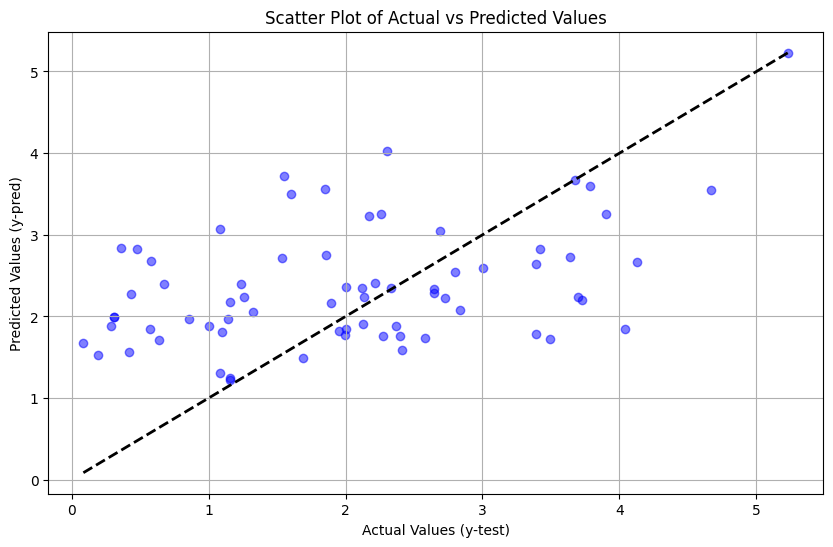

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(y_test, y_pred, color='blue', alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('Actual Values (y-test)')
ax.set_ylabel('Predicted Values (y-pred)')
ax.set_title('Scatter Plot of Actual vs Predicted Values')
ax.grid(True)

plt.show()

### Оцінити важливість змінних (feature importance) за абсолютним значенням коефіцієнта лінійної регресії (якщо feature importance не має змісту, то лише проаналізувати значення коефіцієнтів);

#### Extracting feature names after encoding

In [ ]:
import re

def feature_names_list():
    """
    Remove the beginning of feature names based on the given pattern.

    Parameters:
    - pattern (str): Regular expression pattern to match the beginning of feature names.

    Returns:
    - list: List of feature names with the beginning removed.
    """
    def remove_pattern(name):
        return re.sub(pattern, '', name)

    pattern = r'categoricals__|numericals__'
    feature_names_raw = preprocessor.named_steps['preprocess'].get_feature_names_out()
    feature_names = [remove_pattern(name) for name in feature_names_raw]
    return feature_names

print(feature_names_list())

['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'Y_2', 'Y_3', 'Y_4', 'Y_5', 'Y_6', 'Y_8', 'Y_9', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_oct', 'month_sep', 'day_fri', 'day_mon', 'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']


In [ ]:
coefficients = model.coef_

group1_sum = sum(coefficients[:9])
group2_sum = sum(coefficients[9:16])
group3_sum = sum(coefficients[16:26])
group4_sum = sum(coefficients[26:33])
group5 = coefficients[33:]

feature_names = ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
coef_grouped = [group1_sum, group2_sum, group3_sum, group4_sum] + list(coefficients[33:])

absolute_coefficients = np.abs(coef_grouped)

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef_grouped,
    'Absolute_Coefficient': absolute_coefficients
})

feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False)

print(feature_importance_df)

   Feature   Coefficient  Absolute_Coefficient
6       DC -1.253276e+00          1.253276e+00
5      DMC  4.966813e-01          4.966813e-01
8     temp  2.370077e-01          2.370077e-01
10    wind  1.696037e-01          1.696037e-01
4     FFMC -7.955425e-02          7.955425e-02
7      ISI -5.513754e-02          5.513754e-02
9       RH  5.332967e-02          5.332967e-02
11    rain  5.040800e-03          5.040800e-03
0        X -5.140333e-14          5.140333e-14
2    month  4.574119e-14          4.574119e-14
3      day -2.184364e-14          2.184364e-14
1        Y -4.662937e-15          4.662937e-15


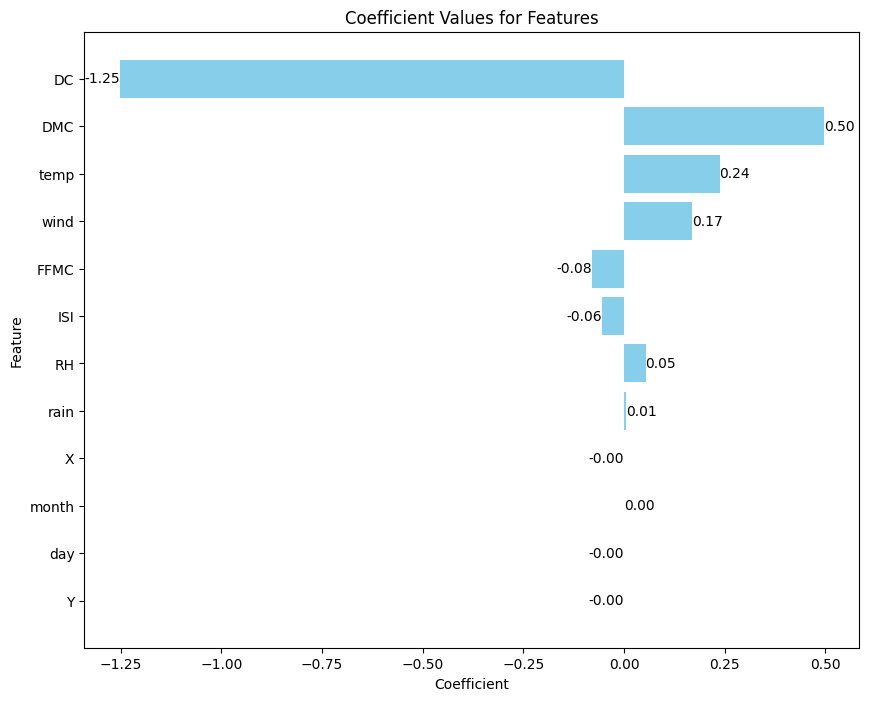

In [ ]:
feature_importance_df_sorted = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))

hbars = ax.barh(feature_importance_df_sorted['Feature'], feature_importance_df_sorted['Coefficient'], color='skyblue')
ax.bar_label(hbars, fmt='{:.2f}')

ax.set_title('Coefficient Values for Features')
ax.set_xlabel('Coefficient')
ax.set_ylabel('Feature')

plt.show()

### Обчислити лишки на тестовій вибірці, провести аналіз лишків (нормальність розподілу, незалежність від вихідної змінної)

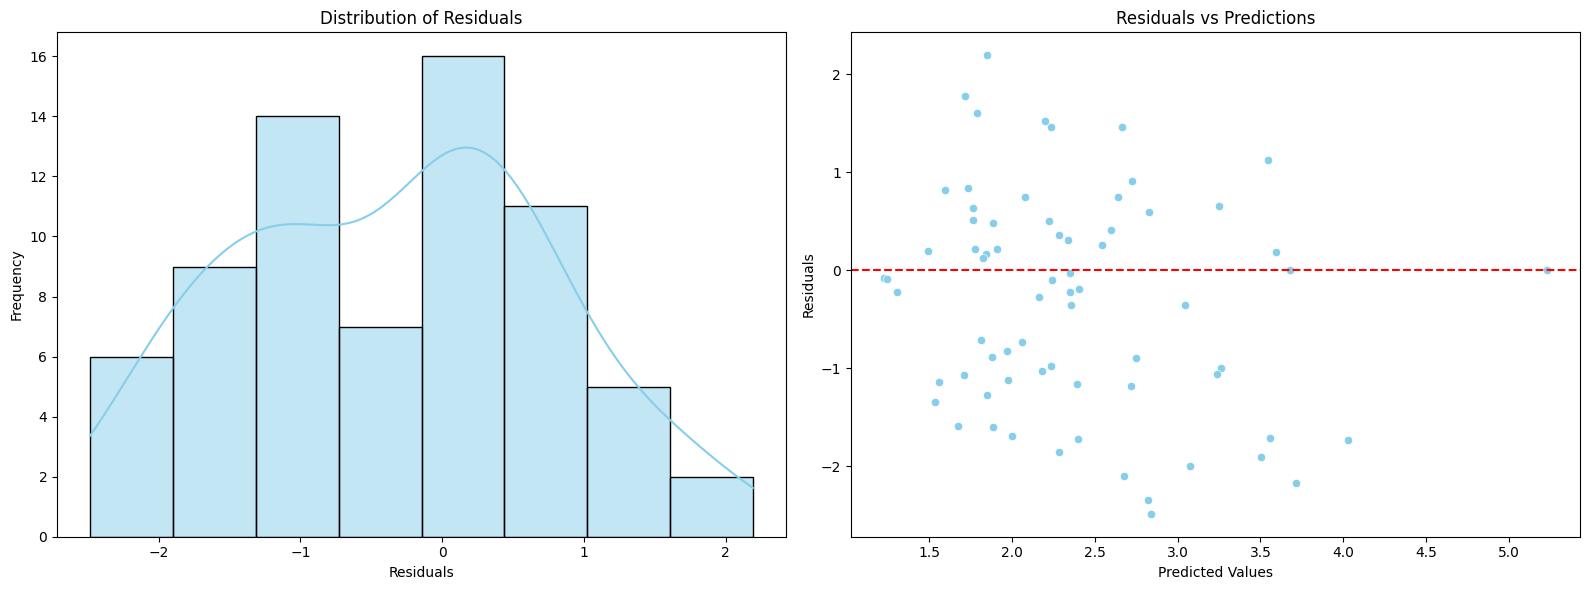

In [ ]:
residuals = y_test - y_pred

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.histplot(residuals, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Residuals')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

sns.scatterplot(x=y_pred, y=residuals, color='skyblue', ax=axes[1])
axes[1].set_title('Residuals vs Predictions')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].axhline(y=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()


*   Розподіл не є нормальним
*   Частина лишків дійсно знаходититься досить близько до осі. Залежності не спостерігається, відносно симетричний до осі.

### Навчити модель на 3 відібраних вхідних змінних (на базі коефіцієнта кореляції, MI чи оцінці розподілі за категоріями проведеними в EDA), обчислити метрики на тестовій вибірці;

In [ ]:
selected_features = ['temp', 'DMC', 'DC']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
model2 = LinearRegression()

model2.fit(X_train_selected, y_train)

y_pred = model2.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 1.4648119198528982
Mean Absolute Error (MAE): 0.9877142247347612
R^2 Score: -0.013830641822846657


### (для СА-33) Навчити модель на топ-3 відібраних вхідних змінних визначених з допомогою SelectKBest, обчислити метрики на тестовій вибірці;

In [ ]:
selector = SelectKBest(score_func=f_regression, k=3)

X_train_selected = selector.fit_transform(X_train_processed, y_train)
X_test_selected = selector.transform(X_test_processed)

model3 = LinearRegression()
model3.fit(X_train_selected, y_train)

y_pred = model3.predict(X_test_selected)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)

Mean Squared Error (MSE): 1.31252073354073
Mean Absolute Error (MAE): 0.9281483396510083
R^2 Score: 0.09157365552771923


In [ ]:
y_test_original_scale = np.exp(y_test) - 1
y_pred_original_scale = np.exp(y_pred) - 1

In [ ]:
mse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
r2 = r2_score(y_test_original_scale, y_pred_original_scale)

real_metrics.append({
    'Model': 'SelectKBest',
    'MSE': mse,
    'MAE': mae,
    'R2': r2
})

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 346.91391086553585
Mean Absolute Error (MAE): 10.272964678914084
R-squared (R2): 0.5378193756381735


## Побудувати модель L1-регуляризованої лінійної регресії Lasso

### Навчити модель Lasso-регресії (на всіх змінних);
### При навчанні, використовуючи крос-валідація та випадковий семплінг параметрів [API: 5], провести тюнинг гіперпараметрів (зокрема, коефіцієнта регуляризації)

In [ ]:
lasso_model = Lasso()

In [ ]:
param_grid = {'alpha': stats.uniform(0,10)}

In [ ]:
random_search = RandomizedSearchCV(estimator=lasso_model, param_distributions=param_grid, n_iter=10, cv=5, random_state=35)

random_search.fit(X_train_processed, y_train)

RandomizedSearchCV(cv=5, estimator=Lasso(),
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f4bec299cc0>},
                   random_state=35)

In [ ]:
print("Best alpha:", random_search.best_params_['alpha'])

Best alpha: 4.580549482240905


In [ ]:
best_lasso_model = random_search.best_estimator_
test_score = best_lasso_model.score(X_test_processed, y_test)
print("Test score:", test_score)

Test score: -0.024939524340718


### Протестувати модель за поданими метриками

In [ ]:
y_pred = best_lasso_model.predict(X_test_processed)

mse = mean_squared_error(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

metrics.append({
    'Model': 'Lasso',
    'MSE': mse,
    'MAE': mae,
    'R2': r2
})

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 1.4808623555540386
Mean Absolute Error (MAE): 0.9925099988466837
R-squared (R2): -0.024939524340718


In [ ]:
y_test_original_scale = np.exp(y_test) - 1
y_pred_original_scale = np.exp(y_pred) - 1

In [ ]:
mse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
r2 = r2_score(y_test_original_scale, y_pred_original_scale)

real_metrics.append({
    'Model': 'Lasso',
    'MSE': mse,
    'MAE': mae,
    'R2': r2
})

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 803.7686857539469
Mean Absolute Error (MAE): 13.242960215464446
R-squared (R2): -0.07083141202784571


### Оцінити коефіцієнти моделі (feature importance) та порівняти її з відповідним результатом звичайної LR

In [ ]:
# Get coefficients of the Lasso regression model
lasso_coefficients = best_lasso_model.coef_

# Create a DataFrame to compare coefficients
comparison_df = pd.DataFrame({
    'Feature': feature_names_list(),  # Assuming X is your input features DataFrame
    'Lasso Coefficients': lasso_coefficients,
    'Linear Regression Coefficients': coefficients  # Coefficients of the ordinary Linear Regression model
})

# Display the comparison DataFrame
print(comparison_df)

      Feature  Lasso Coefficients  Linear Regression Coefficients
0         X_1                 0.0                        0.111191
1         X_2                -0.0                       -0.192107
2         X_3                -0.0                       -0.324065
3         X_4                 0.0                        0.311574
4         X_5                -0.0                       -0.419558
5         X_6                -0.0                        0.019979
6         X_7                 0.0                        0.108013
7         X_8                 0.0                       -0.411999
8         X_9                -0.0                        0.796973
9         Y_2                 0.0                       -0.115428
10        Y_3                 0.0                       -0.500372
11        Y_4                -0.0                       -0.549716
12        Y_5                -0.0                       -0.560911
13        Y_6                 0.0                        0.330494
14        

## Навчити модель L2-регуляризованої лінійної регресії Ridge
### Навчити модель Ridge-регресії (на всіх змінних) з тюнингом гіперпаратмерів, аналогічному до виконаного у Lasso-регресії

In [ ]:
ridge_model = Ridge()

In [ ]:
param_dist = {'alpha': stats.uniform(0, 10)}
random_search = RandomizedSearchCV(ridge_model, param_distributions=param_dist, n_iter=1000, cv=5, random_state=42)

In [ ]:
#grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error')
random_search.fit(X_train_processed, y_train)

RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=1000,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f4bef1702b0>},
                   random_state=42)

In [ ]:
best_alpha = random_search.best_params_['alpha']
print(f'Best alpha: {best_alpha}')

Best alpha: 9.997176732861305


In [ ]:
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(X_train_processed, y_train)

Ridge(alpha=9.997176732861305)

### Протестувати модель за поданими метриками

In [ ]:
y_pred = best_ridge_model.predict(X_test_processed)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics.append({
    'Model': 'Ridge',
    'MSE': mse,
    'MAE': mae,
    'R2': r2
})

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)

Mean Squared Error: 1.4394661823525774
Mean Absolute Error: 1.022099555501472
R^2 Score: 0.0037117368055332722


In [ ]:
y_test_original_scale = np.exp(y_test) - 1
y_pred_original_scale = np.exp(y_pred) - 1

In [ ]:
mse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
r2 = r2_score(y_test_original_scale, y_pred_original_scale)

real_metrics.append({
    'Model': 'Ridge',
    'MSE': mse,
    'MAE': mae,
    'R2': r2
})

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 699.1396267334803
Mean Absolute Error (MAE): 13.697192431000275
R-squared (R2): 0.06856202913979037


### Оцінити feature importance та порівняти її з відповідним результатом звичайної LR

In [ ]:
ridge_coefficients = best_ridge_model.coef_

# Create a DataFrame to compare coefficients
comparison_df = pd.DataFrame({
    'Feature': feature_names_list(),  # Assuming X is your input features DataFrame
    'Ridge Coefficients': ridge_coefficients,
    'Linear Regression Coefficients': coefficients  # Coefficients of the ordinary Linear Regression model
})

# Display the comparison DataFrame
print(comparison_df)

      Feature  Ridge Coefficients  Linear Regression Coefficients
0         X_1            0.093532                        0.111191
1         X_2           -0.169633                       -0.192107
2         X_3           -0.186136                       -0.324065
3         X_4            0.282279                        0.311574
4         X_5           -0.180819                       -0.419558
5         X_6           -0.128347                        0.019979
6         X_7            0.122589                        0.108013
7         X_8            0.115100                       -0.411999
8         X_9            0.051436                        0.796973
9         Y_2            0.039458                       -0.115428
10        Y_3           -0.135367                       -0.500372
11        Y_4           -0.282859                       -0.549716
12        Y_5           -0.227985                       -0.560911
13        Y_6            0.131056                        0.330494
14        

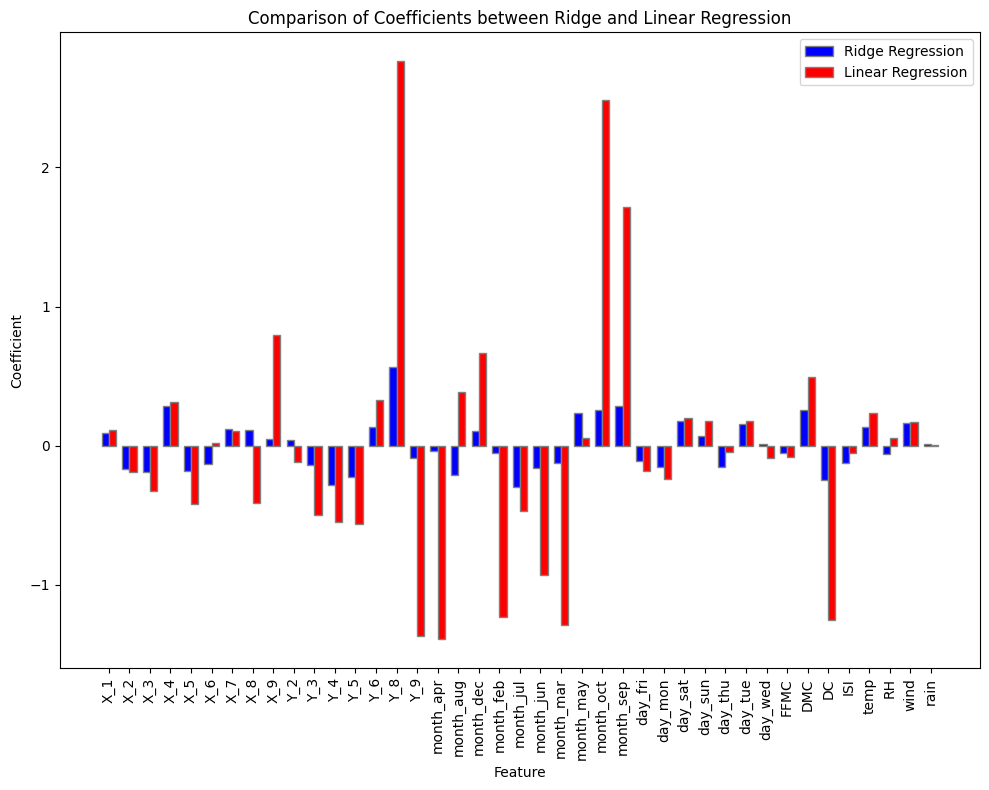

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

features = comparison_df['Feature']
ridge_coefficients = comparison_df['Ridge Coefficients']
linear_regression_coefficients = comparison_df['Linear Regression Coefficients']

bar_width = 0.35

r1 = np.arange(len(features))
r2 = [x + bar_width for x in r1]

ax.bar(r1, ridge_coefficients, color='blue', width=bar_width, edgecolor='grey', label='Ridge Regression')
ax.bar(r2, linear_regression_coefficients, color='red', width=bar_width, edgecolor='grey', label='Linear Regression')

ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient')
ax.set_title('Comparison of Coefficients between Ridge and Linear Regression')
ax.set_xticks([r + bar_width / 2 for r in range(len(features))])
ax.set_xticklabels(features, rotation=90)
ax.legend()

plt.tight_layout()
plt.show()


### Обчислити лишки на тестовій вибірці, провести аналіз лишків (нормальність розподілу, незалежність від вихідної змінної)

In [ ]:
# 1. Зробіть прогнози на тестових даних з використанням навченої моделі Ridge
y_pred_ridge = best_ridge_model.predict(X_test_processed)

# 2. Обчисліть лишки
residuals_ridge = y_test - y_pred_ridge

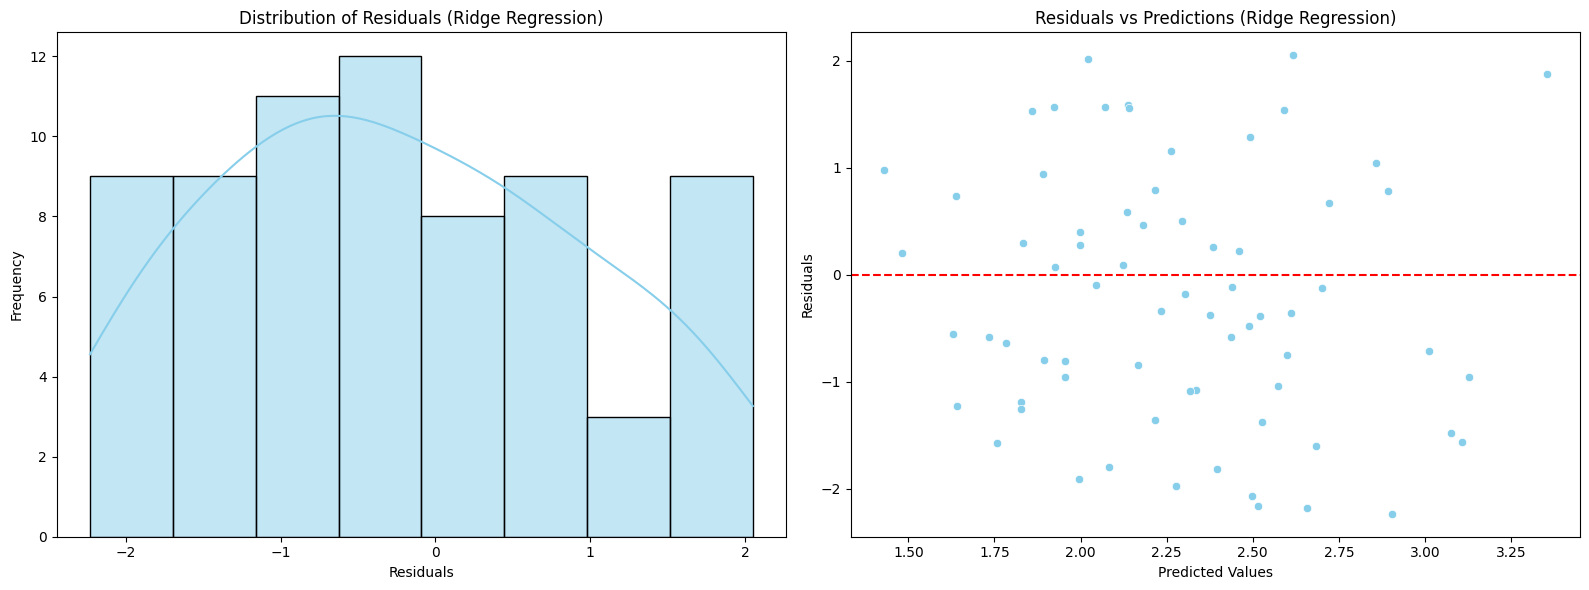

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Аналіз нормальності розподілу
sns.histplot(residuals_ridge, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Distribution of Residuals (Ridge Regression)')
axes[0].set_xlabel('Residuals')
axes[0].set_ylabel('Frequency')

# Аналіз незалежності від вихідної змінної
sns.scatterplot(x=y_pred_ridge, y=residuals_ridge, color='skyblue', ax=axes[1])
axes[1].set_title('Residuals vs Predictions (Ridge Regression)')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].axhline(y=0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

*   Розподіл не є нормальним
*   Залежність на графіку не спостерігається?? Не можу стверджувати симетричність. Більшість точок далеко від осі.



## Вивести порівняльну таблицю для чотирьох моделей по всім заданим метрикам, зробити відповідні висновки.

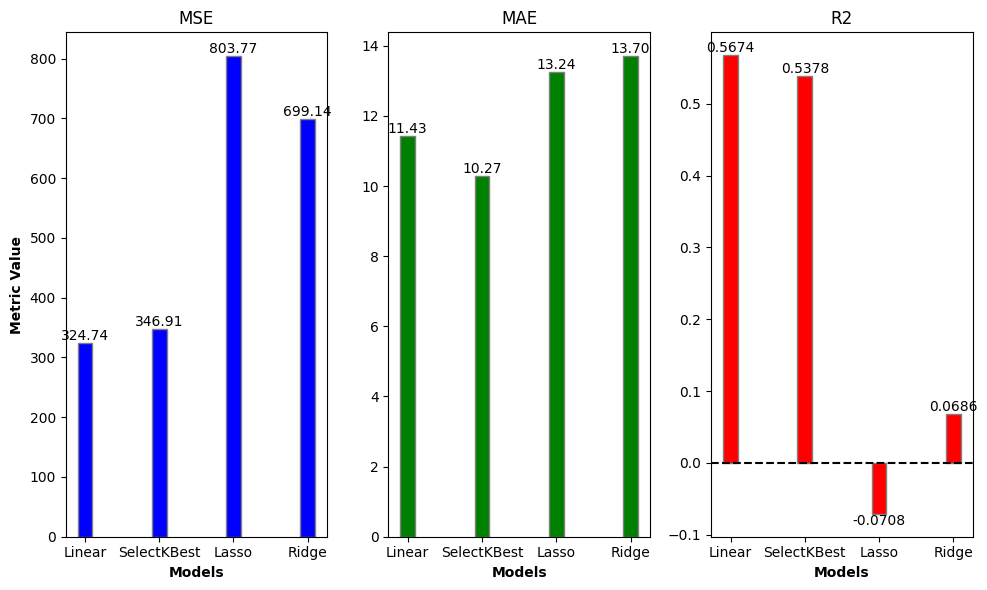

In [ ]:
model_names = [metric['Model'] for metric in real_metrics]
mse_values = [metric['MSE'] for metric in real_metrics]
mae_values = [metric['MAE'] for metric in real_metrics]
r2_values = [metric['R2'] for metric in real_metrics]

bar_width = 0.2
r1 = np.arange(len(model_names))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

bar_width = 0.2
r = np.arange(len(model_names))

fig, axs = plt.subplots(figsize=(10, 6), nrows=1, ncols=3)

bar1 = axs[0].bar(r, mse_values, color='b', width=bar_width, edgecolor='grey', label='MSE')
axs[0].set_title('MSE')
axs[0].set_ylabel('Metric Value', fontweight='bold')
axs[0].set_xticks(r)
axs[0].set_xticklabels(model_names)
axs[0].bar_label(bar1, fmt='{:.2f}')

bar2 = axs[1].bar(r, mae_values, color='g', width=bar_width, edgecolor='grey', label='MAE')
axs[1].set_title('MAE')
axs[1].set_xticks(r)
axs[1].set_xticklabels(model_names)
axs[1].bar_label(bar2, fmt='{:.2f}')

bar3 = axs[2].bar(r, r2_values, color='r', width=bar_width, edgecolor='grey', label='R2')
axs[2].set_title('R2')
axs[2].set_xticks(r)
axs[2].set_xticklabels(model_names)
axs[2].bar_label(bar3, fmt='{:.4f}')
axs[2].axhline(y=0, color='black', linestyle='--')

for ax in axs:
    ax.set_xlabel('Models', fontweight='bold')

plt.tight_layout()
plt.show()

## Висновки

*   Найкращі результати показали Linear Regression та SelectKBest
*   Найгірший (ніякий) результат показала Lasso, адже повністю занулилися всі коефіцієнти (неправильно обрано параметр?)



# Lab 03

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/kaggle/diabetes_data.csv')

print(df)

        Age  Sex  HighChol  CholCheck   BMI  Smoker  HeartDiseaseorAttack  \
0       4.0  1.0       0.0        1.0  26.0     0.0                   0.0   
1      12.0  1.0       1.0        1.0  26.0     1.0                   0.0   
2      13.0  1.0       0.0        1.0  26.0     0.0                   0.0   
3      11.0  1.0       1.0        1.0  28.0     1.0                   0.0   
4       8.0  0.0       0.0        1.0  29.0     1.0                   0.0   
...     ...  ...       ...        ...   ...     ...                   ...   
70687   6.0  0.0       1.0        1.0  37.0     0.0                   0.0   
70688  10.0  1.0       1.0        1.0  29.0     1.0                   1.0   
70689  13.0  0.0       1.0        1.0  25.0     0.0                   1.0   
70690  11.0  0.0       1.0        1.0  18.0     0.0                   0.0   
70691   9.0  0.0       1.0        1.0  25.0     0.0                   1.0   

       PhysActivity  Fruits  Veggies  HvyAlcoholConsump  GenHlth  MentHlth 

<body>
    <table border="1">
        <tr>
            <th>Attribute</th>
            <th>Description</th>
        </tr>
        <tr>
            <td>Age</td>
            <td>13-level age category (_AGEG5YR see codebook) 1 = 18-24 9 = 60-64 13 = 80 or older</td>
        </tr>
        <tr>
            <td>Sex</td>
            <td>patient's gender (1: male; 0: female)</td>
        </tr>
        <tr>
            <td>HighChol</td>
            <td>0 = no high cholesterol 1 = high cholesterol</td>
        </tr>
        <tr>
            <td>CholCheck</td>
            <td>0 = no cholesterol check in 5 years 1 = yes cholesterol check in 5 years</td>
        </tr>
        <tr>
            <td>BMI</td>
            <td>Body Mass Index</td>
        </tr>
        <tr>
            <td>Smoker</td>
            <td>Have you smoked at least 100 cigarettes in your entire life? [Note: 5 packs = 100 cigarettes] 0 = no 1 = yes</td>
        </tr>
        <tr>
            <td>HeartDiseaseorAttack</td>
            <td>coronary heart disease (CHD) or myocardial infarction (MI) 0 = no 1 = yes</td>
        </tr>
        <tr>
            <td>PhysActivity</td>
            <td>physical activity in past 30 days - not including job 0 = no 1 = yes</td>
        </tr>
        <tr>
            <td>Fruits</td>
            <td>Consume Fruit 1 or more times per day 0 = no 1 = yes</td>
        </tr>
        <tr>
            <td>VeggiesConsume</td>
            <td>Consume Vegetables 1 or more times per day 0 = no 1 = yes</td>
        </tr>
        <tr>
            <td>HvyAlcoholConsump</td>
            <td>(adult men >=14 drinks per week and adult women>=7 drinks per week) 0 = no 1 = yes</td>
        </tr>
        <tr>
            <td>GenHlth</td>
            <td>Would you say that in general your health is: scale 1-5 1 = excellent 2 = very good 3 = good 4 = fair 5 = poor</td>
        </tr>
        <tr>
            <td>MentHlth</td>
            <td>days of poor mental health scale 1-30 days</td>
        </tr>
        <tr>
            <td>PhysHlth</td>
            <td>physical illness or injury days in past 30 days scale 1-30</td>
        </tr>
        <tr>
            <td>DiffWal</td>
            <td>Do you have serious difficulty walking or climbing stairs? 0 = no 1 = yes</td>
        </tr>
    </table>
</body>

In [ ]:
def get_metrics(y_test, y_pred, svc):
  if svc == False:
    y_prob = best_model.predict_proba(X_test_processed)[:,1]
    # Calculate binary crossentropy
    binary_crossentropy_logistic = log_loss(y_test, y_prob)

    # Calculate accuracy
    accuracy_logistic = accuracy_score(y_test, y_pred)

    # Calculate precision
    precision_logistic = precision_score(y_test, y_pred)

    # Calculate recall
    recall_logistic = recall_score(y_test, y_pred)

    # Calculate F1 score
    f1_logistic = f1_score(y_test, y_pred)

    # Calculate ROC AUC score
    roc_auc_logistic = roc_auc_score(y_test, y_prob)

    return(binary_crossentropy_logistic, accuracy_logistic, precision_logistic, recall_logistic, f1_logistic, roc_auc_logistic)

  else:
    # Calculate accuracy
    accuracy_logistic = accuracy_score(y_test, y_pred)

    # Calculate precision
    precision_logistic = precision_score(y_test, y_pred)

    # Calculate recall
    recall_logistic = recall_score(y_test, y_pred)

    # Calculate F1 score
    f1_logistic = f1_score(y_test, y_pred)

    return(accuracy_logistic, precision_logistic, recall_logistic, f1_logistic)


## Провести первинний та ED аналіз даних, необхідний для визначення кроків препроцесингу даних (потенційно для кожної з моделей)

In [ ]:
df.head()

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0
4,8.0,0.0,0.0,1.0,29.0,1.0,0.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


### Check target variable (binary and balanced???)

In [ ]:
df['Diabetes'].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: Diabetes, dtype: float64

In [ ]:
df['Diabetes'].value_counts()

0.0    35346
1.0    35346
Name: Diabetes, dtype: int64

### Data shape

In [ ]:
# shape of data
print(f'Shape of data: {df.shape}')

# amount of rows (data)
print(f'Amount of rows: {df.shape[0]}')

# amount of columns (variables)
print(f'Amount of columns: {df.shape[1]}')

Shape of data: (70692, 18)
Amount of rows: 70692
Amount of columns: 18


### Duplicates

In [ ]:
# amount of duplicates
print(f'Amount of duplicates: {df.duplicated().sum()}')

# duplicates = df[df.duplicated(keep=False)]
# print(duplicates)

Amount of duplicates: 6672


### Data types

In [ ]:
print(f'Data types:\n{df.dtypes}')

Data types:
Age                     float64
Sex                     float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Stroke                  float64
HighBP                  float64
Diabetes                float64
dtype: object


### Unique values

In [ ]:
print('Uniques: ')
df.nunique()

Uniques: 


Age                     13
Sex                      2
HighChol                 2
CholCheck                2
BMI                     80
Smoker                   2
HeartDiseaseorAttack     2
PhysActivity             2
Fruits                   2
Veggies                  2
HvyAlcoholConsump        2
GenHlth                  5
MentHlth                31
PhysHlth                31
DiffWalk                 2
Stroke                   2
HighBP                   2
Diabetes                 2
dtype: int64

### Divide on binary (as categorical) and multi-value as numerical

In [ ]:
binary_columns = []
multi_value_columns = []

for col in df.drop(columns=['Diabetes']).columns:
    unique_values = df[col].unique()
    if len(unique_values) <= 2:
        binary_columns.append(col)
    else:
        multi_value_columns.append(col)

### Distribution

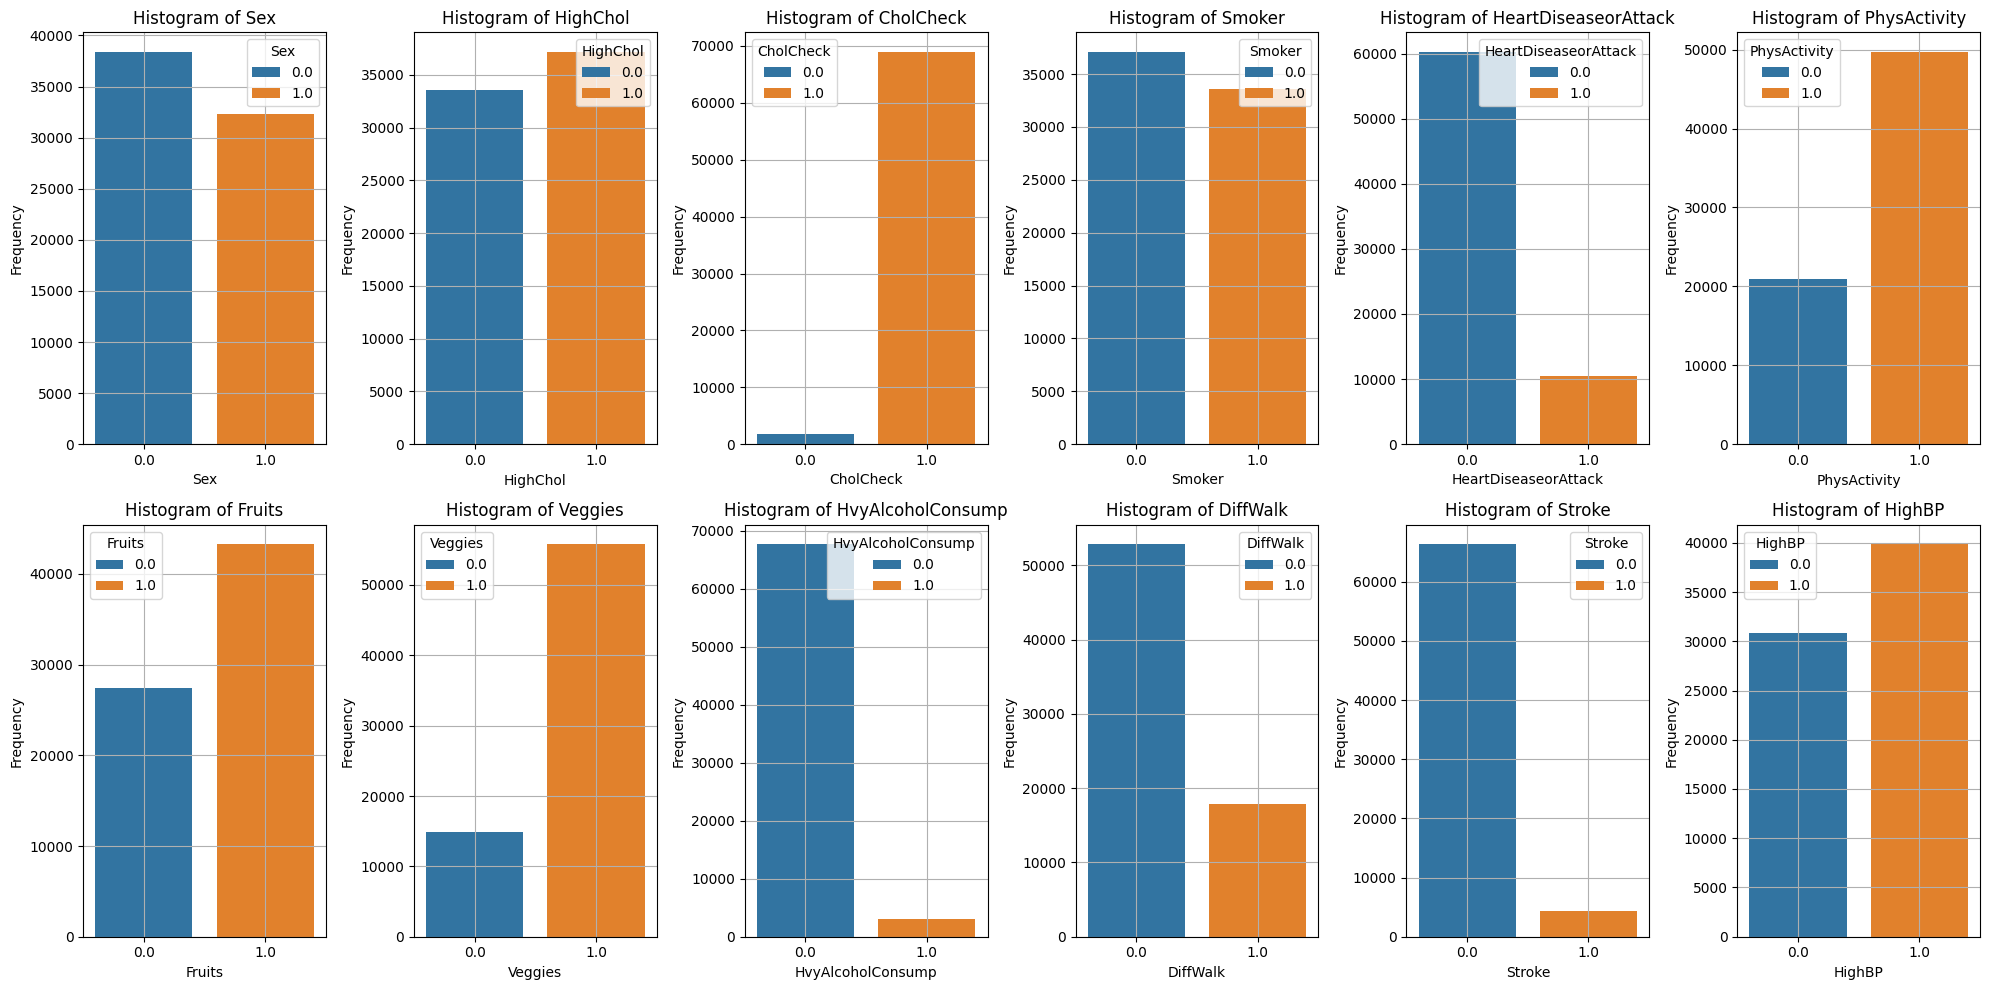

In [ ]:
fig, axes = plt.subplots(2, 6, figsize=(20, 10))
axes = axes.flatten()

# Iterate over binary columns and plot count plots
for i, data in enumerate(binary_columns):
    sns.countplot( x=df[data], ax=axes[i], hue=df[data])
    axes[i].set_title(f'Histogram of {data}')
    axes[i].set_xlabel(data)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

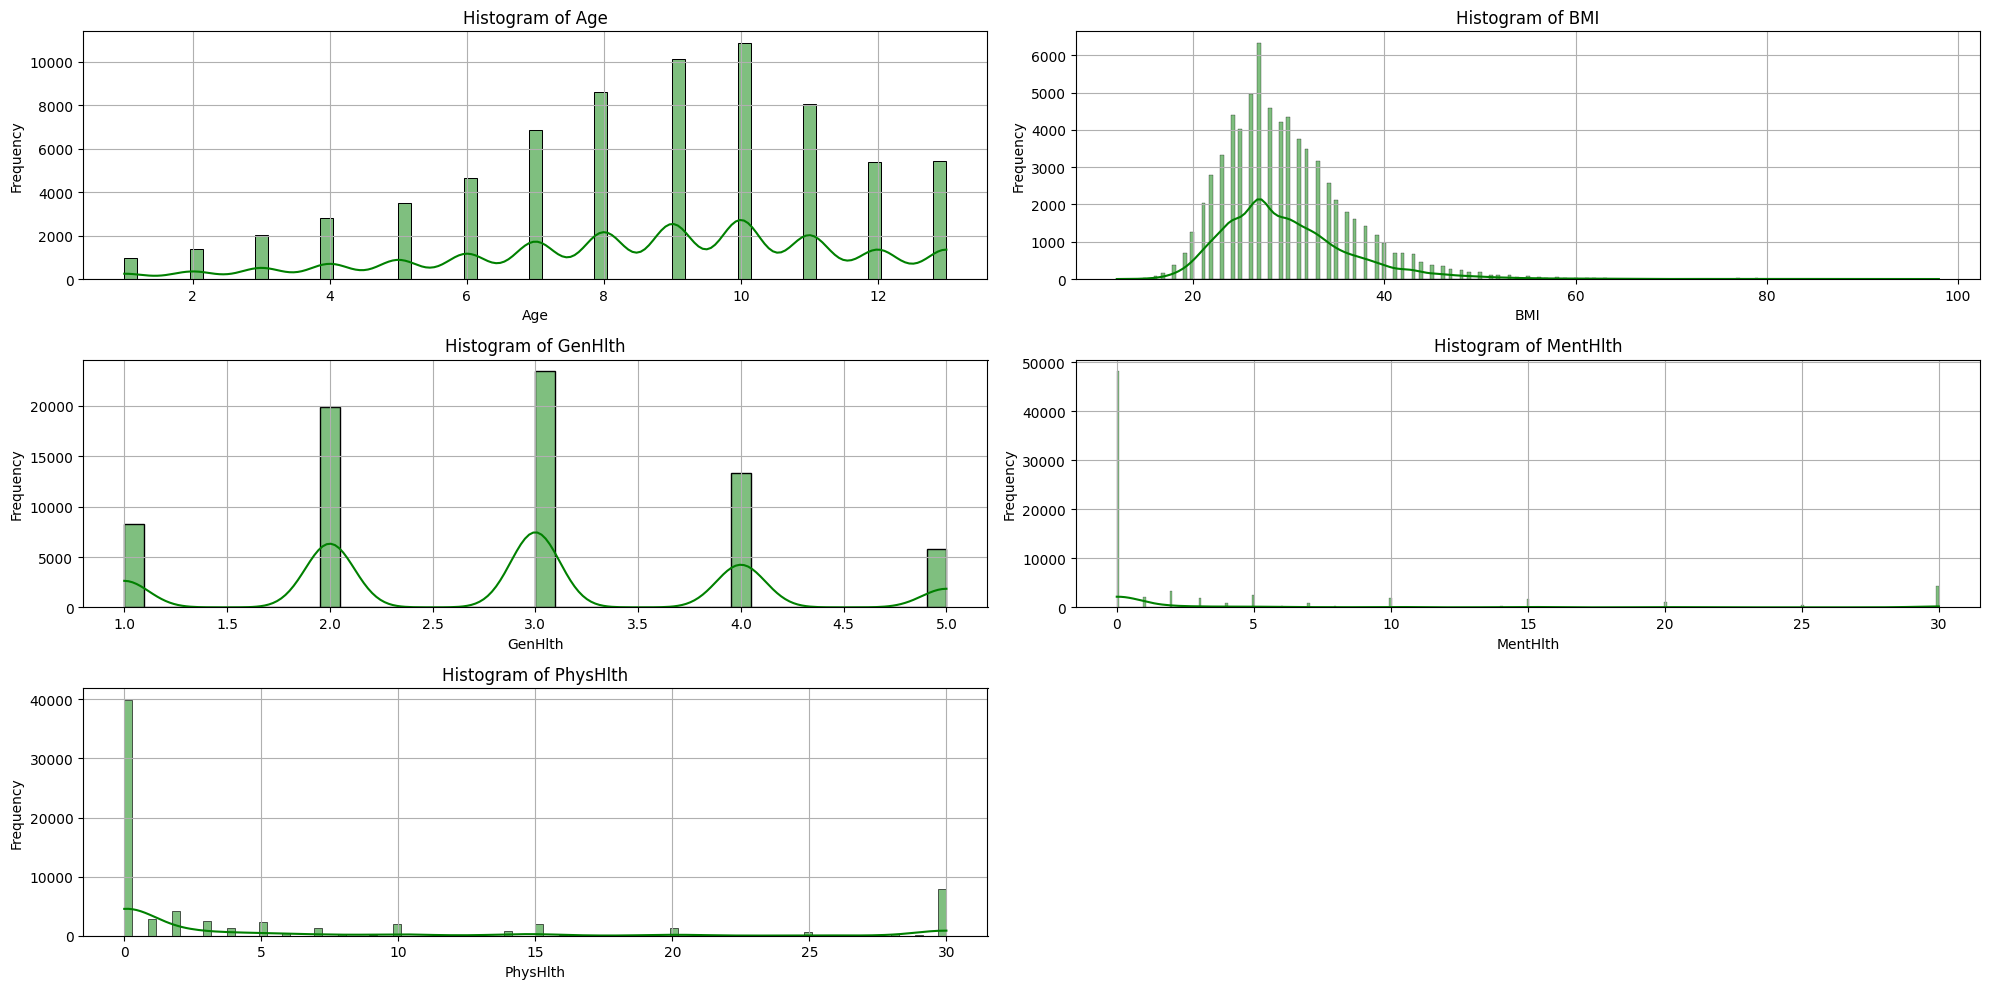

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(20, 10))
fig.delaxes(axes[2,1])
axes = axes.flatten()

# Iterate over binary columns and plot count plots
for i, data in enumerate(multi_value_columns):
    sns.histplot( x=df[data], ax=axes[i], kde=True, color='green')
    axes[i].set_title(f'Histogram of {data}')
    axes[i].set_xlabel(data)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

#### Descriptive stats for numerical

In [ ]:
desc_st = df[multi_value_columns].describe()

print(f'Descriptive statistic for numerical features:\n\n{desc_st}')

Descriptive statistic for numerical features:

                Age           BMI       GenHlth      MentHlth      PhysHlth
count  70692.000000  70692.000000  70692.000000  70692.000000  70692.000000
mean       8.584055     29.856985      2.837082      3.752037      5.810417
std        2.852153      7.113954      1.113565      8.155627     10.062261
min        1.000000     12.000000      1.000000      0.000000      0.000000
25%        7.000000     25.000000      2.000000      0.000000      0.000000
50%        9.000000     29.000000      3.000000      0.000000      0.000000
75%       11.000000     33.000000      4.000000      2.000000      6.000000
max       13.000000     98.000000      5.000000     30.000000     30.000000


### Outliers

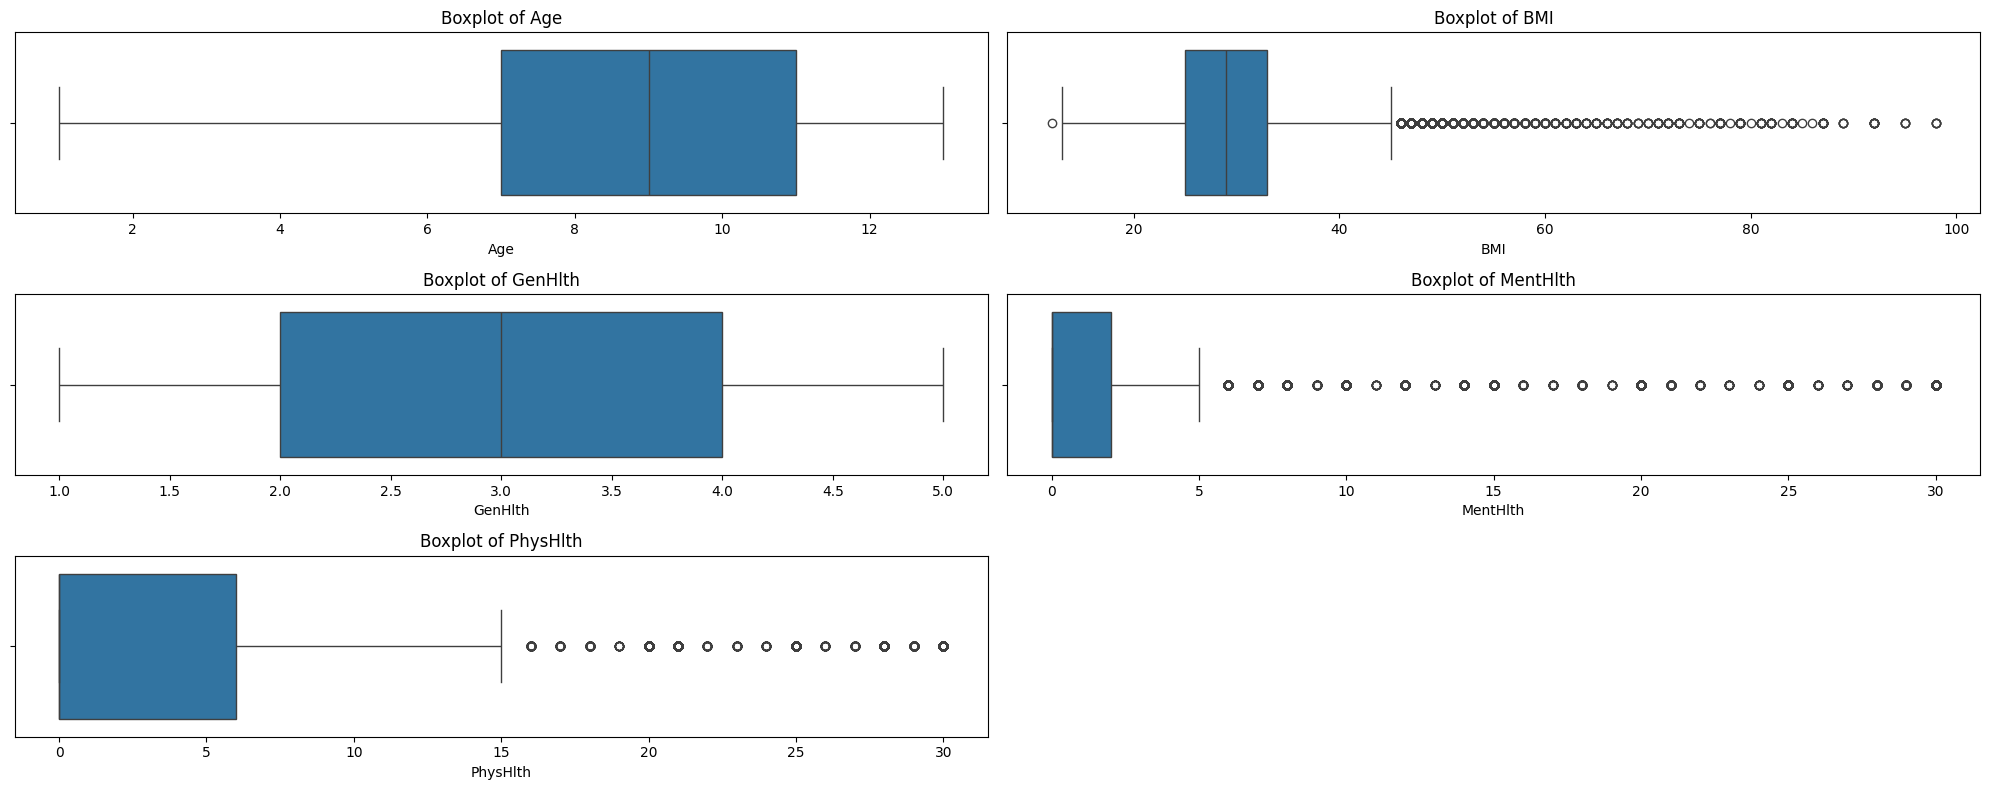

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 8))
fig.delaxes(axes[2,1])

axes = axes.flatten()

for i, data in enumerate(df[multi_value_columns]):
    sns.boxplot(x=df[data], ax=axes[i])
    axes[i].set_title(f"Boxplot of {data}")

plt.tight_layout()
plt.show()

In [ ]:
def detect_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (data < lower_bound) | (data > upper_bound)
    return np.sum(outliers), np.mean(outliers)

In [ ]:
for column in multi_value_columns:
  num_outliers, percentage_outliers = detect_outliers(df[column])
  print(f"Number of outliers in {column}:", num_outliers)
  print(f"Percentage of outliers {column}:", percentage_outliers * 100, "%\n")

Number of outliers in Age: 0
Percentage of outliers Age: 0.0 %

Number of outliers in BMI: 2181
Percentage of outliers BMI: 3.085214734340519 %

Number of outliers in GenHlth: 0
Percentage of outliers GenHlth: 0.0 %

Number of outliers in MentHlth: 11816
Percentage of outliers MentHlth: 16.714762632263906 %

Number of outliers in PhysHlth: 10624
Percentage of outliers PhysHlth: 15.028574661913655 %



### Missing values in numerical

In [ ]:
print("\nMissing values in numerical:")
print(df[multi_value_columns].isnull().sum())


Missing values in numerical:
Age         0
BMI         0
GenHlth     0
MentHlth    0
PhysHlth    0
dtype: int64


### Missing value in binary

In [ ]:
print("\nMissing values in binary:")
print(df[binary_columns].isnull().sum())


Missing values in binary:
Sex                     0
HighChol                0
CholCheck               0
Smoker                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
DiffWalk                0
Stroke                  0
HighBP                  0
dtype: int64


### Correlation matrix

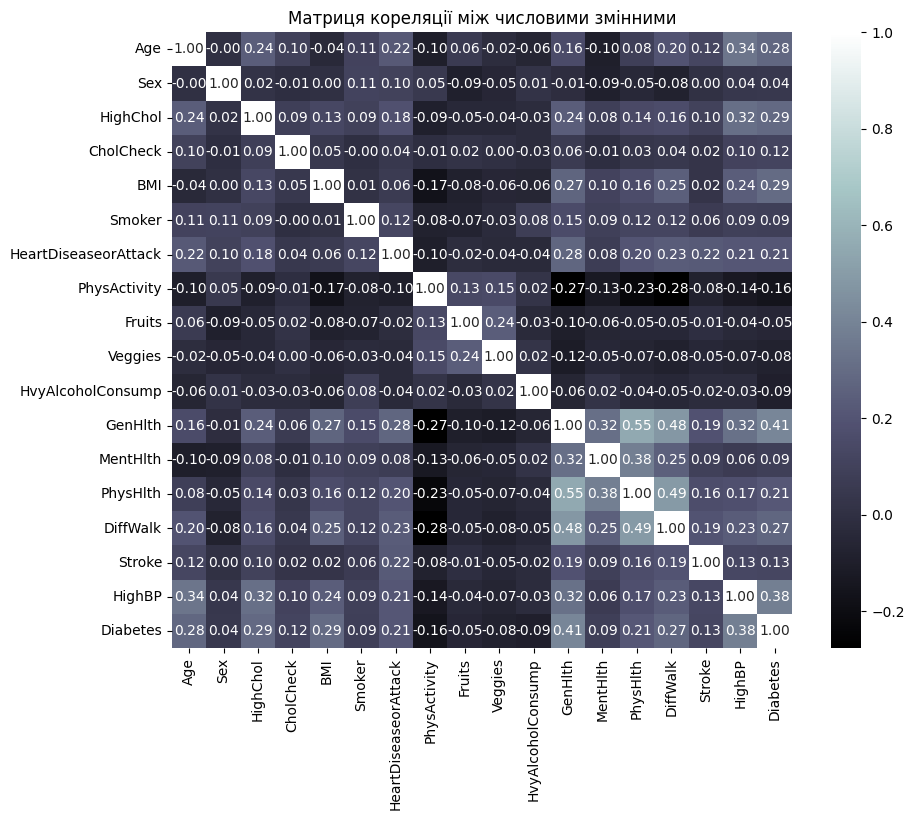

In [ ]:
correlation_matrix = df.corr()

print('\n')

fig, axes = plt.subplots(1,1, figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='bone', fmt=".2f", ax=axes)
axes.set_title('Матриця кореляції між числовими змінними')
plt.show()

In [ ]:
threshold = 0.7

high_correlation_pairs = []

print("Strong correlation (>0.5/<-0.5):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            high_correlation_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j]))
            print(f"{correlation_matrix.index[i]} - {correlation_matrix.columns[j]}: {np.round(correlation_matrix.iloc[i, j], 2)}")


Strong correlation (>0.5/<-0.5):


### MI Score

In [ ]:
# Mutual information quantifies the amount of information obtained about one variable through the observation of another variable.
# In this context, it measures the dependency between each numerical feature in numeric_data and the target variable 'area'.

mi_scores = {}

for column in df.drop(columns=['Diabetes']).columns:
    # Compute mutual information score between the current column and the 'area' column
    mi_score = mutual_info_regression(df[[column]], df['Diabetes'])[0]
    mi_scores[column] = mi_score

# Convert the dictionary to a DataFrame
mi_scores_df = pd.DataFrame.from_dict(mi_scores, orient='index', columns=['MI Score'])

# Sort the DataFrame by MI Score in descending order
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False)


In [ ]:
def addlabels(x, y, j):
    for i in range(len(x)):
        axes[j].text(i, y[i], round(y[i], 2), ha='center')

<ipython-input-27-387fa11cb166>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=mi_scores_df.index, y=mi_scores_df['MI Score'], palette='viridis', ax=axes)
<ipython-input-27-387fa11cb166>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(mi_scores_df.index, rotation=90)


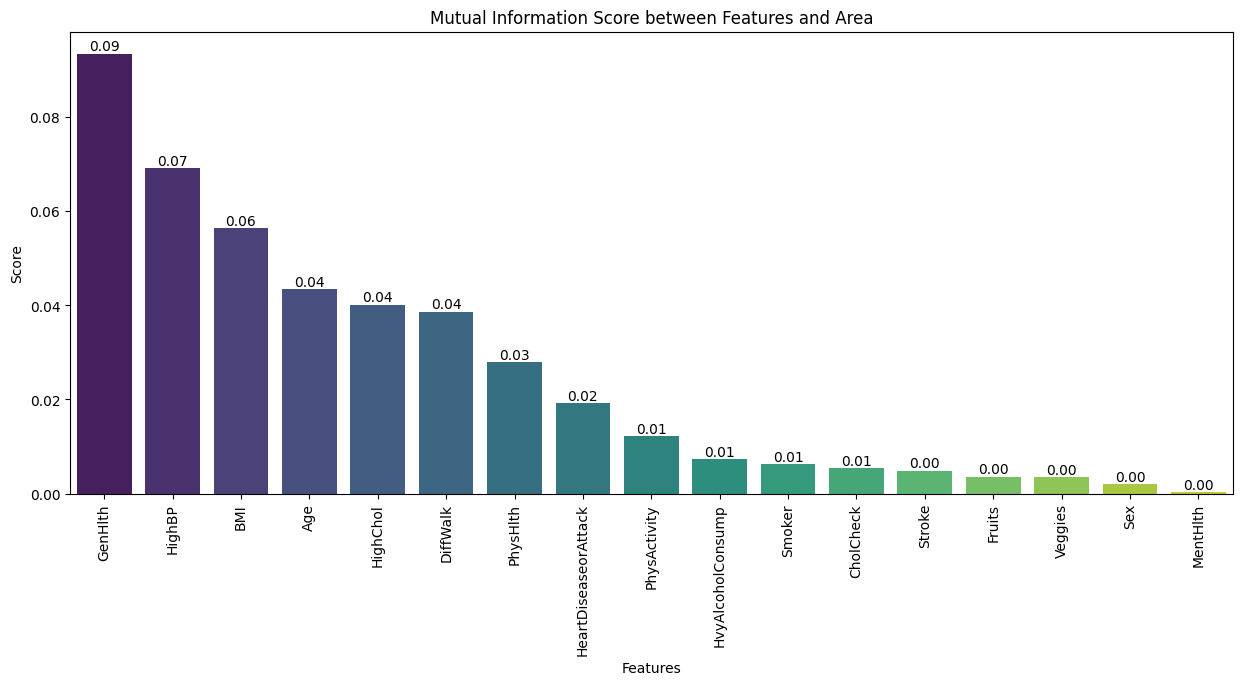

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharey = True)

bars = sns.barplot(x=mi_scores_df.index, y=mi_scores_df['MI Score'], palette='viridis', ax=axes)
axes.set_title('Mutual Information Score between Features and Area')
axes.set_xlabel('Features')
axes.set_ylabel('Score')
axes.set_xticklabels(mi_scores_df.index, rotation=90)

for i in bars.containers:
    bars.bar_label(i, fmt='{:.2f}')

### T-test

In [ ]:
# List to store results
results = []

# Iterate through each column
for col in binary_columns:
    # Extract data for each category
    cat1 = df[df[col] == 1].index
    cat0 = df[df[col] == 0].index

    # Perform t-test
    t_stat, p_value = stats.ttest_ind(cat1, cat0)

    # Save results
    results.append({
        'Column': col,
        'T-Statistic': t_stat,
        'P-Value': p_value
    })

# Create DataFrame from results
results_df = pd.DataFrame(results)

# Print results
print(results_df)

                  Column  T-Statistic        P-Value
0                    Sex    10.462865   1.335634e-25
1               HighChol    68.851949   0.000000e+00
2              CholCheck    26.687544  3.921243e-156
3                 Smoker    18.896698   1.907917e-79
4   HeartDiseaseorAttack    49.688632   0.000000e+00
5           PhysActivity   -38.285716   0.000000e+00
6                 Fruits   -13.393637   7.389350e-41
7                Veggies   -17.928330   1.022570e-71
8      HvyAlcoholConsump   -21.690180  5.555292e-104
9               DiffWalk    64.819124   0.000000e+00
10                Stroke    28.620532  3.954045e-179
11                HighBP    92.335268   0.000000e+00


In [ ]:
significant_results = results_df[results_df['P-Value'] < 0.05]

print(significant_results)

                  Column  T-Statistic        P-Value
0                    Sex    10.462865   1.335634e-25
1               HighChol    68.851949   0.000000e+00
2              CholCheck    26.687544  3.921243e-156
3                 Smoker    18.896698   1.907917e-79
4   HeartDiseaseorAttack    49.688632   0.000000e+00
5           PhysActivity   -38.285716   0.000000e+00
6                 Fruits   -13.393637   7.389350e-41
7                Veggies   -17.928330   1.022570e-71
8      HvyAlcoholConsump   -21.690180  5.555292e-104
9               DiffWalk    64.819124   0.000000e+00
10                Stroke    28.620532  3.954045e-179
11                HighBP    92.335268   0.000000e+00


## На базі проведеного аналізу побудувати пайплайн(-и) препроцесингу даних (потенційно для кожної з моделей окремо)

In [ ]:
column_transformer = ColumnTransformer(
    transformers=[
        ('scaling', StandardScaler(), multi_value_columns)
    ],
    remainder='passthrough'  # Щоб зберегти інші колонки без змін
)

pipeline = Pipeline(steps=[
    ('preprocessing', column_transformer)
])

# data frame mapper

## Розділити дані на тренувальну та тестову вибірки (зі стратифікацією), “навчити” препроцесинг на тренувальній вибірці, трансформувати тренувальну та тестову вибірки.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Diabetes']), df['Diabetes'], test_size=0.2, stratify=df['Diabetes'], random_state=42)

In [ ]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

## Побудувати модель логістичної регресії

### Навчити модель логістичної регресії з тюнингом гіперпараметрів (зокрема, параметрами регуляризації)

In [ ]:
log_reg = LogisticRegression(max_iter=50)

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'saga', 'sag']
}

In [ ]:
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_processed, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 210.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=50),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga', 'sag']},
             scoring='accuracy')

In [ ]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_processed)
y_prob = best_model.predict_proba(X_test_processed)[:,1]  # Predicted probabilities for positive class

### Обчислити задані метрики для моделі, побудувати (запрінтити) classification report [API: 4]

In [ ]:
binary_crossentropy_logistic, accuracy_logistic, precision_logistic, recall_logistic, f1_logistic, roc_auc_logistic = get_metrics(y_test, y_pred, False)

# # Calculate binary crossentropy
# binary_crossentropy_logistic = log_loss(y_test, y_prob)

# # Calculate accuracy
# accuracy_logistic = accuracy_score(y_test, y_pred)

# # Calculate precision
# precision_logistic = precision_score(y_test, y_pred)

# # Calculate recall
# recall_logistic = recall_score(y_test, y_pred)

# # Calculate F1 score
# f1_logistic = f1_score(y_test, y_pred)

# # Calculate ROC AUC score
# roc_auc_logistic = roc_auc_score(y_test, y_prob)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74      7070
         1.0       0.74      0.76      0.75      7069

    accuracy                           0.75     14139
   macro avg       0.75      0.75      0.75     14139
weighted avg       0.75      0.75      0.75     14139



### Побудувати матриці невідповідностей (confusion matrix [API: 5]) (без нормалізації, та дві нормалізованих (по recall та по precision, див. параметр normalize у відповідному API sklearn))

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

conf_matrix_recall = confusion_matrix(y_test, y_pred, normalize='true')

conf_matrix_precision = confusion_matrix(y_test, y_pred, normalize='pred')

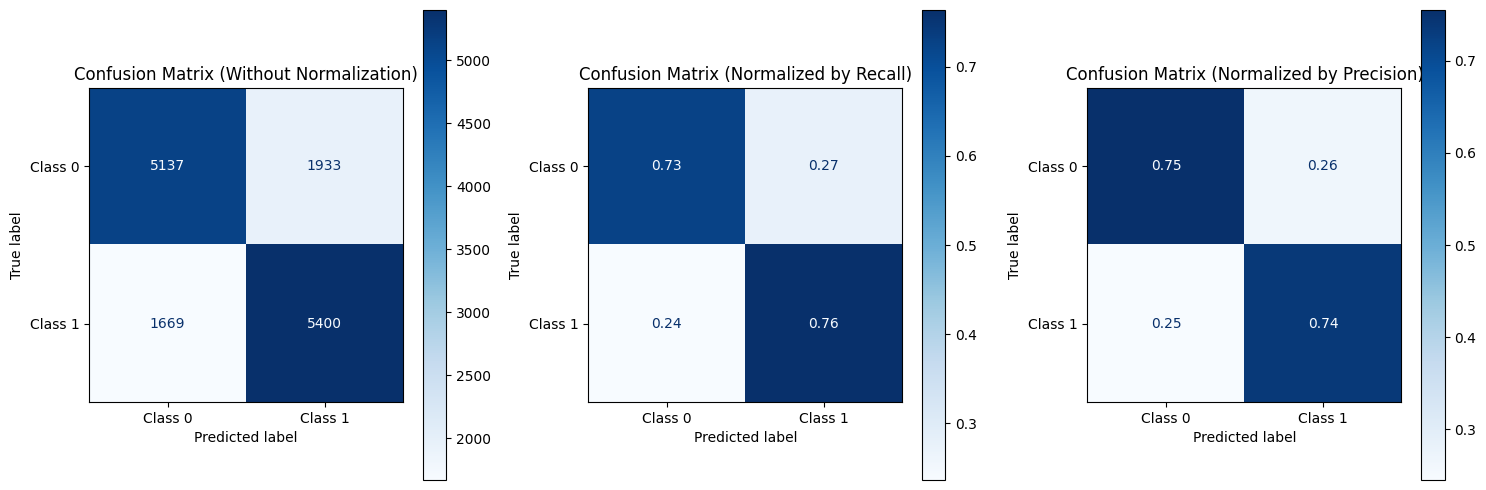

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues, ax=axes[0], values_format='d')
axes[0].set_title('Confusion Matrix (Without Normalization)')

disp_recall = ConfusionMatrixDisplay(conf_matrix_recall, display_labels=['Class 0', 'Class 1'])
disp_recall.plot(cmap=plt.cm.Blues, ax=axes[1], values_format='.2f')
axes[1].set_title('Confusion Matrix (Normalized by Recall)')

disp_precision = ConfusionMatrixDisplay(conf_matrix_precision, display_labels=['Class 0', 'Class 1'])
disp_precision.plot(cmap=plt.cm.Blues, ax=axes[2], values_format='.2f')
axes[2].set_title('Confusion Matrix (Normalized by Precision)')

plt.tight_layout()
plt.show()

### Побудувати ROC криву для моделі [API: 6]

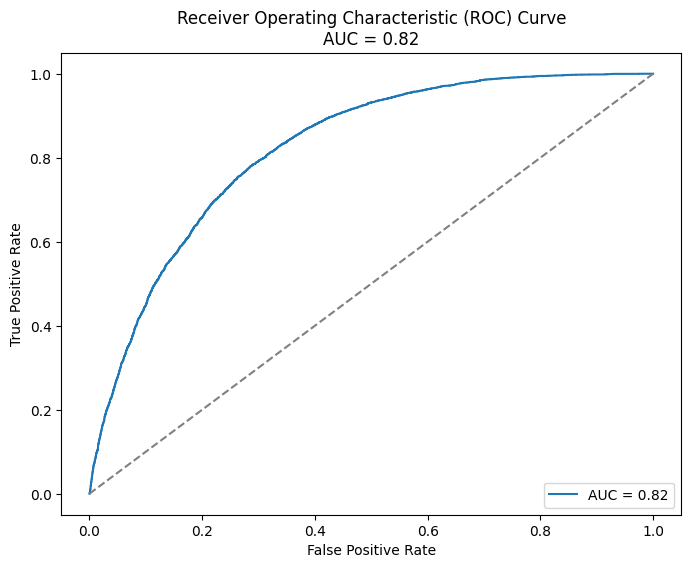

In [ ]:
# Calculate AUC
auc = roc_auc_score(y_test, y_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc)
roc_display.plot(ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Plot random classifier line
ax.set_title('Receiver Operating Characteristic (ROC) Curve\nAUC = {:.2f}'.format(auc))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')

plt.show()

### Оцінити та відобразити feature importance за значеннями коефіцієнтів регресійної моделі (за умови скейлінгу/нормалізації фіч)

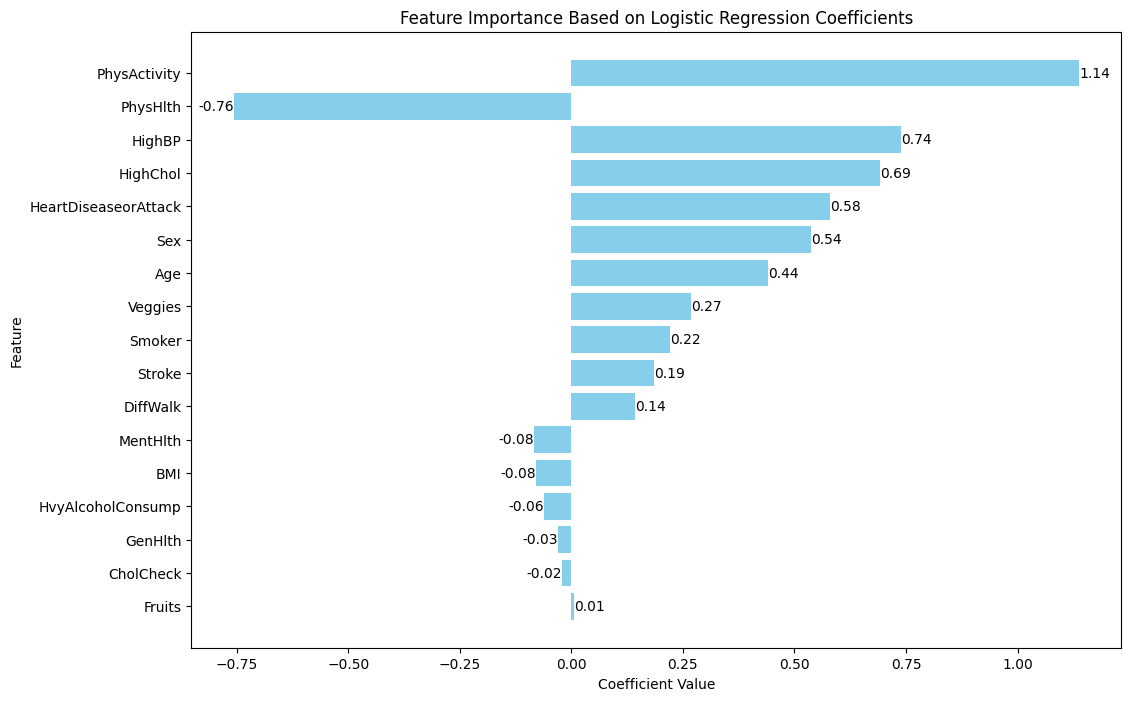

In [ ]:
# Get feature names
feature_names = X_train.columns

# Get coefficients from the model
coefficients = best_model.coef_[0]

# Create a DataFrame to store feature names and their corresponding coefficients
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by absolute coefficient values in descending order
feature_importance_df = feature_importance_df.reindex(feature_importance_df['Coefficient'].abs().sort_values(ascending=False).index)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.barh(feature_importance_df['Feature'], feature_importance_df['Coefficient'], color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance Based on Logistic Regression Coefficients')
ax.bar_label(bars, fmt='{:.2f}')
ax.invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

In [ ]:
# Print the metrics
print("Binary Crossentropy:", binary_crossentropy_logistic)
print("Accuracy:", accuracy_logistic)
print("Precision:", precision_logistic)
print("Recall:", recall_logistic)
print("F1 Score:", f1_logistic)
print("ROC AUC Score:", roc_auc_logistic)

Binary Crossentropy: 0.5157768419902972
Accuracy: 0.7452436523092156
Precision: 0.7363971089594982
Recall: 0.7638987126892064
F1 Score: 0.7498958477989168
ROC AUC Score: 0.8216326719267324


## Побудувати SVM класифікатор (1 - SVC з тюнингом ядра та 2 - LinearSVC)

In [ ]:
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(df.drop(columns=['Diabetes']), df['Diabetes'], test_size=0.7, stratify=df['Diabetes'], random_state=42)

In [ ]:
X_train_processed_7 = pipeline.fit_transform(X_train_7)
X_test_processed_7 = pipeline.transform(X_test_7)

### Навчити SVM класифікатори з тюнингом гіперпаметрів (для SVC не включати linear в можливі значення ядра)

In [ ]:
svm_kernel = SVC(max_iter=3)

In [ ]:
param_grid_kernel = {
    'C': np.logspace(0, 10),  # Regularization parameter
    'gamma': np.logspace(-3, 3, 7),  # Kernel coefficient
    'kernel': ['linear', 'poly', 'rbf']  # Kernel type
}

In [ ]:
grid_search_kernel = RandomizedSearchCV(estimator=svm_kernel, param_distributions=param_grid_kernel, cv=5, scoring='accuracy')
grid_search_kernel.fit(X_train_processed_7, y_train_7)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=3).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=3).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=3).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=3).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=3).  Consider pre-processing

RandomizedSearchCV(cv=5, estimator=SVC(max_iter=3),
                   param_distributions={'C': array([1.00000000e+00, 1.59985872e+00, 2.55954792e+00, 4.09491506e+00,
       6.55128557e+00, 1.04811313e+01, 1.67683294e+01, 2.68269580e+01,
       4.29193426e+01, 6.86648845e+01, 1.09854114e+02, 1.75751062e+02,
       2.81176870e+02, 4.49843267e+02, 7.19685673e+02, 1.15139540e+03,
       1.84206997e+03, 2.94705170e+0...
       3.39322177e+06, 5.42867544e+06, 8.68511374e+06, 1.38949549e+07,
       2.22299648e+07, 3.55648031e+07, 5.68986603e+07, 9.10298178e+07,
       1.45634848e+08, 2.32995181e+08, 3.72759372e+08, 5.96362332e+08,
       9.54095476e+08, 1.52641797e+09, 2.44205309e+09, 3.90693994e+09,
       6.25055193e+09, 1.00000000e+10]),
                                        'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'kernel': ['linear', 'poly', 'rbf']},
                   scoring='accuracy')

In [ ]:
best_svm_kernel = grid_search_kernel.best_estimator_

In [ ]:
svm_linear = LinearSVC(max_iter=50)

In [ ]:
param_grid_linear = {
    'C': [0.1, 1, 10]
}

In [ ]:
grid_search_linear = GridSearchCV(estimator=svm_linear, param_grid=param_grid_linear, cv=5, scoring='accuracy')
grid_search_linear.fit(X_train_processed_7, y_train_7)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

GridSearchCV(cv=5, estimator=LinearSVC(max_iter=50),
             param_grid={'C': [0.1, 1, 10]}, scoring='accuracy')

In [ ]:
best_svm_linear = grid_search_linear.best_estimator_

In [ ]:
# Evaluate the models
print("SVM Classifier with Kernel Tuning (Best Parameters):", best_svm_kernel)
print("SVM Classifier without Kernel Tuning (Best Parameters):", best_svm_linear)

SVM Classifier with Kernel Tuning (Best Parameters): SVC(C=126485.52168552957, gamma=0.01, kernel='linear', max_iter=3)
SVM Classifier without Kernel Tuning (Best Parameters): LinearSVC(C=0.1, max_iter=50)


In [ ]:
# Predictions
y_pred_kernel = best_svm_kernel.predict(X_test_processed_7)
y_pred_linear = best_svm_linear.predict(X_test_processed_7)

### Обчислити задані метрики для моделей, побудувати classification report

In [ ]:
# Classification reports
print("\nClassification Report for SVM Classifier with Kernel Tuning:")
print(classification_report(y_test_7, y_pred_kernel))

print("\nClassification Report for SVM Classifier without Kernel Tuning:")
print(classification_report(y_test_7, y_pred_linear))


Classification Report for SVM Classifier with Kernel Tuning:
              precision    recall  f1-score   support

         0.0       0.49      0.61      0.54     24743
         1.0       0.48      0.36      0.41     24742

    accuracy                           0.49     49485
   macro avg       0.49      0.49      0.48     49485
weighted avg       0.49      0.49      0.48     49485


Classification Report for SVM Classifier without Kernel Tuning:
              precision    recall  f1-score   support

         0.0       0.76      0.72      0.74     24743
         1.0       0.74      0.78      0.76     24742

    accuracy                           0.75     49485
   macro avg       0.75      0.75      0.75     49485
weighted avg       0.75      0.75      0.75     49485



### Побудувати матриці невідповідностей (confusion matrix [API: 5]) (без нормалізації, та дві нормалізованих)

In [ ]:
# Confusion matrix without normalization for SVM with kernel tuning
conf_matrix_kernel = confusion_matrix(y_test_7, y_pred_kernel)

# Confusion matrix without normalization for SVM without kernel tuning
conf_matrix_linear = confusion_matrix(y_test_7, y_pred_linear)

# Confusion matrix normalized by recall for SVM with kernel tuning
conf_matrix_normalized_recall_kernel = confusion_matrix(y_test_7, y_pred_kernel, normalize='true')

# Confusion matrix normalized by recall for SVM without kernel tuning
conf_matrix_normalized_recall_linear = confusion_matrix(y_test_7, y_pred_linear, normalize='true')

# Confusion matrix normalized by precision for SVM with kernel tuning
conf_matrix_normalized_precision_kernel = confusion_matrix(y_test_7, y_pred_kernel, normalize='pred')

# Confusion matrix normalized by precision for SVM without kernel tuning
conf_matrix_normalized_precision_linear = confusion_matrix(y_test_7, y_pred_linear, normalize='pred')

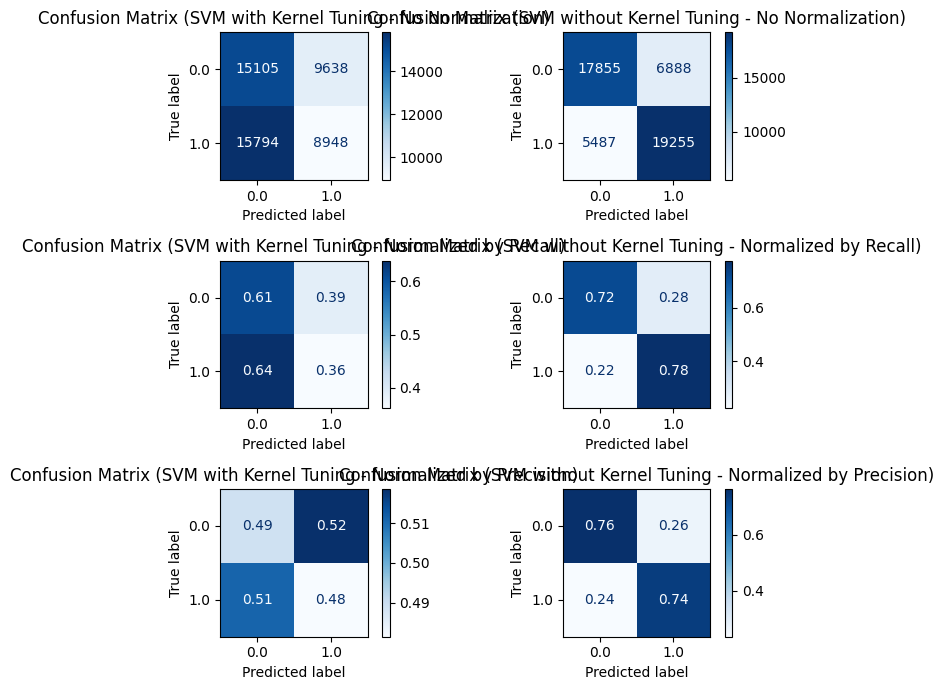

In [ ]:
# Plotting
fig, axes = plt.subplots(3, 2, figsize=(7, 7))

# Confusion matrix without normalization for SVM with kernel tuning
disp_kernel = ConfusionMatrixDisplay(conf_matrix_kernel, display_labels=best_svm_kernel.classes_)
disp_kernel.plot(ax=axes[0, 0], cmap=plt.cm.Blues, values_format='d')
axes[0, 0].set_title('Confusion Matrix (SVM with Kernel Tuning - No Normalization)')

# Confusion matrix without normalization for SVM without kernel tuning
disp_linear = ConfusionMatrixDisplay(conf_matrix_linear, display_labels=best_svm_linear.classes_)
disp_linear.plot(ax=axes[0, 1], cmap=plt.cm.Blues, values_format='d')
axes[0, 1].set_title('Confusion Matrix (SVM without Kernel Tuning - No Normalization)')

# Confusion matrix normalized by recall for SVM with kernel tuning
disp_normalized_recall_kernel = ConfusionMatrixDisplay(conf_matrix_normalized_recall_kernel, display_labels=best_svm_kernel.classes_)
disp_normalized_recall_kernel.plot(ax=axes[1, 0], cmap=plt.cm.Blues, values_format='.2f')
axes[1, 0].set_title('Confusion Matrix (SVM with Kernel Tuning - Normalized by Recall)')

# Confusion matrix normalized by recall for SVM without kernel tuning
disp_normalized_recall_linear = ConfusionMatrixDisplay(conf_matrix_normalized_recall_linear, display_labels=best_svm_linear.classes_)
disp_normalized_recall_linear.plot(ax=axes[1, 1], cmap=plt.cm.Blues, values_format='.2f')
axes[1, 1].set_title('Confusion Matrix (SVM without Kernel Tuning - Normalized by Recall)')

# Confusion matrix normalized by precision for SVM with kernel tuning
disp_normalized_precision_kernel = ConfusionMatrixDisplay(conf_matrix_normalized_precision_kernel, display_labels=best_svm_kernel.classes_)
disp_normalized_precision_kernel.plot(ax=axes[2, 0], cmap=plt.cm.Blues, values_format='.2f')
axes[2, 0].set_title('Confusion Matrix (SVM with Kernel Tuning - Normalized by Precision)')

# Confusion matrix normalized by precision for SVM without kernel tuning
disp_normalized_precision_linear = ConfusionMatrixDisplay(conf_matrix_normalized_precision_linear, display_labels=best_svm_linear.classes_)
disp_normalized_precision_linear.plot(ax=axes[2, 1], cmap=plt.cm.Blues, values_format='.2f')
axes[2, 1].set_title('Confusion Matrix (SVM without Kernel Tuning - Normalized by Precision)')

plt.tight_layout()
plt.show()

### Побудувати ROC криві для моделей

In [ ]:
# Calculate ROC curves
fpr_kernel, tpr_kernel, _ = roc_curve(y_test, best_svm_kernel.decision_function(X_test_processed))
fpr_linear, tpr_linear, _ = roc_curve(y_test, best_svm_linear.decision_function(X_test_processed))


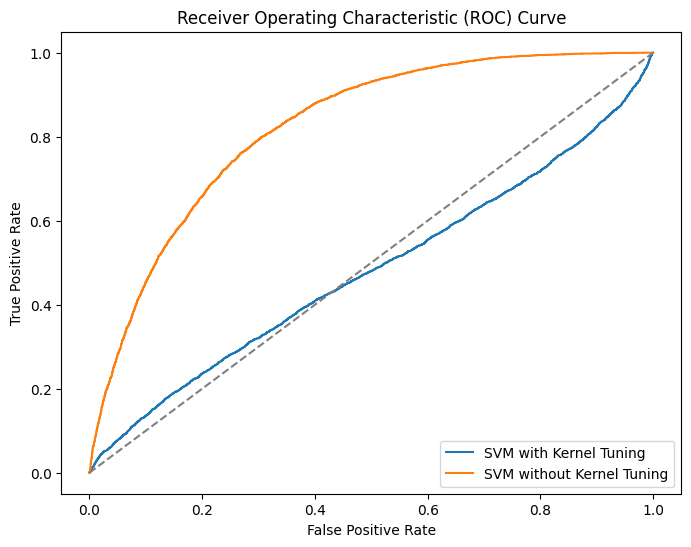

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plot ROC curve for SVM with kernel tuning
roc_display_kernel = RocCurveDisplay(fpr=fpr_kernel, tpr=tpr_kernel, estimator_name='SVM with Kernel Tuning')
roc_display_kernel.plot(ax=ax)

# Plot ROC curve for SVM without kernel tuning
roc_display_linear = RocCurveDisplay(fpr=fpr_linear, tpr=tpr_linear, estimator_name='SVM without Kernel Tuning')
roc_display_linear.plot(ax=ax)

# Plot random classifier line
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customize plot
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')

plt.show()

## Вивести порівняльну таблицю для моделей по всім заданим метрикам, зробити відповідні висновки.

Метрики: binary crossentropy, accuracy, precision/recall, F₁, ROC AUC.

In [ ]:
binary_crossentropy_logistic_l, accuracy_logistic_l, precision_logistic_l, recall_logistic_l, f1_logistic_l, roc_auc_logistic_l = get_metrics(y_test, y_pred, False)
accuracy_logistic_k, precision_logistic_k, recall_logistic_k, f1_logistic_k = get_metrics(y_test_7, y_pred_kernel, True)
accuracy_logistic_ls, precision_logistic_ls, recall_logistic_ls, f1_logistic_ls = get_metrics(y_test_7, y_pred_linear, True)


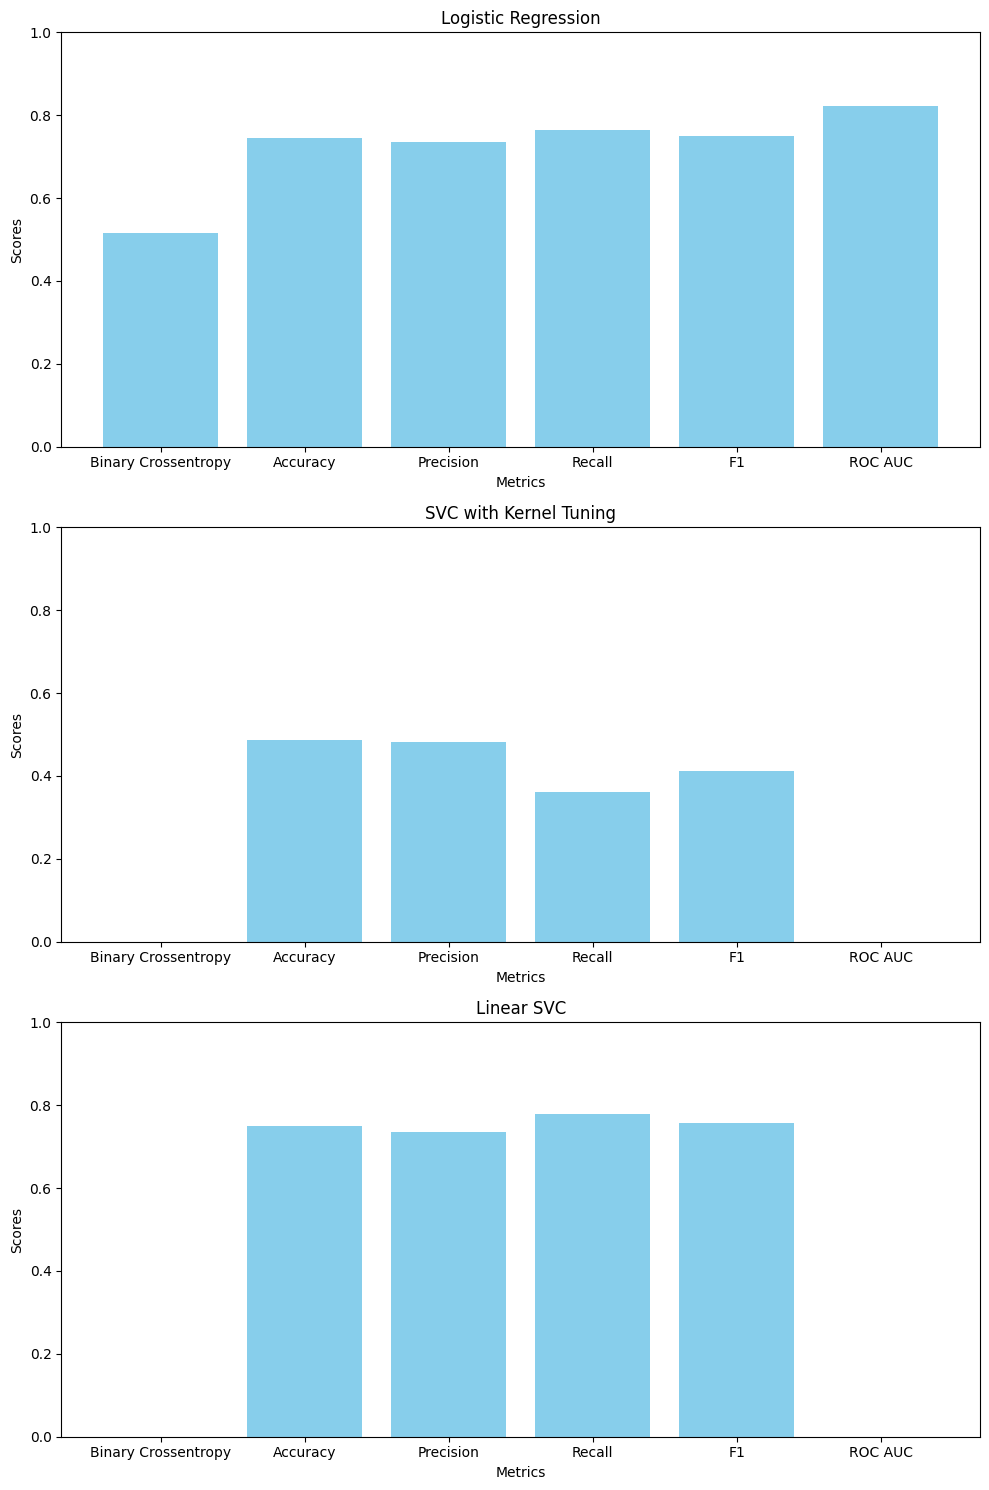

In [ ]:
models = ['Logistic Regression', 'SVC with Kernel Tuning', 'Linear SVC']
metrics_names = ['Binary Crossentropy', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']

metrics_values_dict = {
    'Logistic Regression': [binary_crossentropy_logistic_l, accuracy_logistic_l, precision_logistic_l, recall_logistic_l, f1_logistic_l, roc_auc_logistic_l],
    'SVC with Kernel Tuning': [0, accuracy_logistic_k, precision_logistic_k, recall_logistic_k, f1_logistic_k, 0],
    'Linear SVC': [0, accuracy_logistic_ls, precision_logistic_ls, recall_logistic_ls, f1_logistic_ls, 0]
}

fig, axs = plt.subplots(3, 1, figsize=(10, 15))


for i, model in enumerate(models):
    ax = axs[i]
    metrics_values = metrics_values_dict[model]
    x = np.arange(len(metrics_names))
    ax.bar(x, metrics_values, color='skyblue')
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(model)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_names)
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Lab 04

## Провести первинний та ED аналіз даних, необхідний для визначення кроків препроцесингу даних (потенційно для кожної з моделей);

## На базі проведеного аналізу побудувати пайплайн(-и) препроцесингу даних [API: 1], (потенційно для кожної моделі окремо);

## На базі проведено аналізу обрати метод агрегування метрик (precision, recall, F1) доступних в sklearn (weighted, macro чи micro);

##